In [236]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from imblearn.over_sampling import SMOTE

In [237]:
# load data
df = pd.read_excel("../data/raw/Telco_customer_churn_adapted_v2.xlsx")
df_ori = df.copy()

In [117]:
df_ori.describe().T

,count,mean,std,min,25%,50%,75%,max
Customer ID,7043.0,3521.000000,2033.283305,0.000000,1760.500000,3521.000000,5281.50000,7042.00000
Tenure Months,7043.0,32.371149,24.559481,0.000000,9.000000,29.000000,55.00000,72.00000
Monthly Purchase (Thou. IDR),7043.0,84.190200,39.117061,23.725000,46.150000,91.455000,116.80500,154.37500
Longitude,7043.0,107.043246,0.358316,106.816666,106.816666,106.816666,107.60981,107.60981
Latitude,7043.0,-6.404184,0.322898,-6.914744,-6.914744,-6.200000,-6.20000,-6.20000
CLTV (Predicted Thou. IDR),7043.0,5720.384481,1537.974298,2603.900000,4509.700000,5885.100000,6994.65000,8450.00000


In [118]:
df_ori.describe(exclude="number").T

,count,unique,top,freq
Location,7043,2,Jakarta,5031
Device Class,7043,3,High End,3096
Games Product,7043,3,No,3498
Music Product,7043,3,No,3088
Education Product,7043,3,No,3095
Call Center,7043,2,No,4999
Video Product,7043,3,No,2810
Use MyApp,7043,3,No,2785
Payment Method,7043,4,Pulsa,2365
Churn Label,7043,2,No,5174


# Background

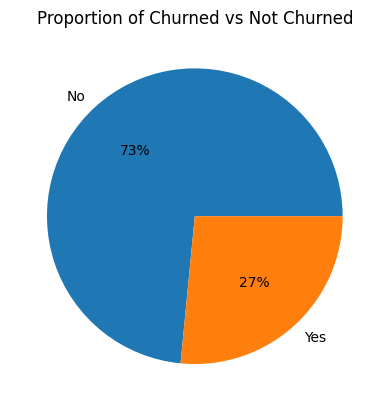

In [119]:
plot_df = df['Churn Label'].value_counts(normalize=True)*100
plt.pie(plot_df, labels=plot_df.index, autopct='%.0f%%')
plt.title("Proportion of Churned vs Not Churned")
plt.show()

27% of passengers churned from purchasing

In [120]:
display(df.groupby("Churn Label")["CLTV (Predicted Thou. IDR)"].sum())
display(df.groupby("Churn Label")["Monthly Purchase (Thou. IDR)"].sum())

Churn Label
No     30206835.1
Yes    10081832.8
Name: CLTV (Predicted Thou. IDR), dtype: float64

Churn Label
No     412081.475
Yes    180870.105
Name: Monthly Purchase (Thou. IDR), dtype: float64

Around `Rp10,081,832,800.00` potential income in the future gone.

Around `Rp180,870,800.00` stripped out from the company's monthly income.

# EDA

## Univariate

### Original

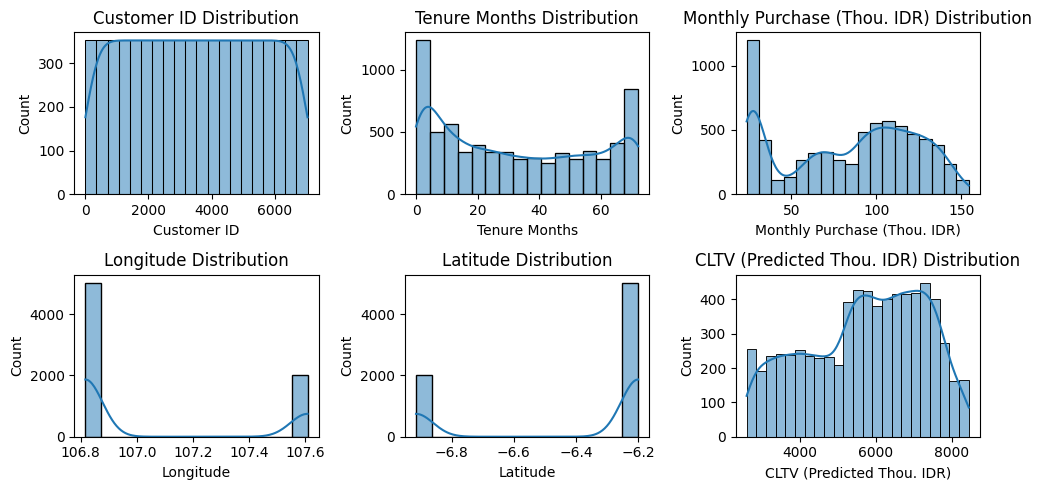

In [121]:
numerical_columns = df.select_dtypes(include=[int, float]).columns
fig, ax = plt.subplots(nrows=int(len(numerical_columns)//3), ncols=3, figsize=(10, 5))

i = 0 # for accessing array of column names
for rows in ax: # access rows of subplots
    for col in rows: # access column inside subplot rows
        sns.histplot(data=df, x=numerical_columns[i], kde=True, ax=col)
        col.set_title(f"{numerical_columns[i]} Distribution")
        i+=1
fig.tight_layout()

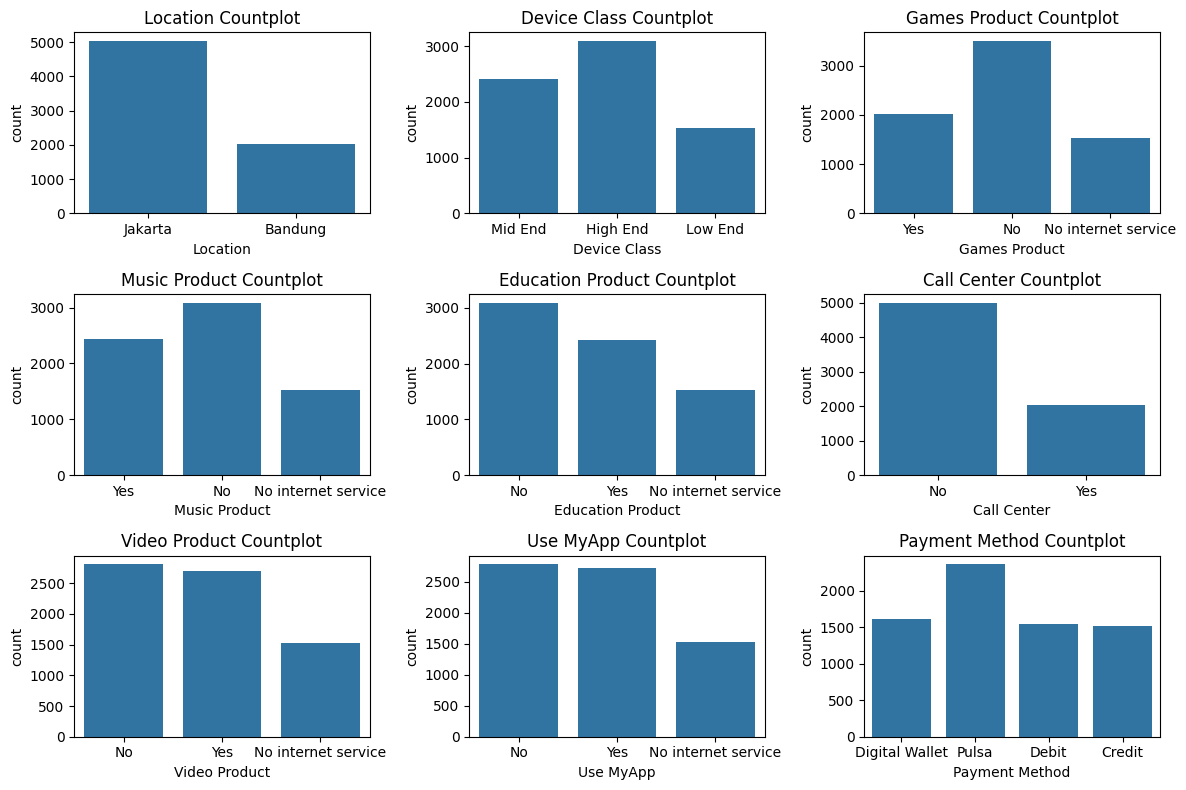

In [122]:
numerical_columns = df.select_dtypes(include=[object]).columns
fig, ax = plt.subplots(nrows=int(len(numerical_columns)//3), ncols=3, figsize=(12, 8))

i = 0 # for accessing array of column names
for rows in ax: # access rows of subplots
    for col in rows: # access column inside subplot rows
        sns.countplot(data=df,x=numerical_columns[i], ax=col)
        col.set_title(f"{numerical_columns[i]} Countplot")
        i+=1
fig.tight_layout()

### Hue `Churn Label`

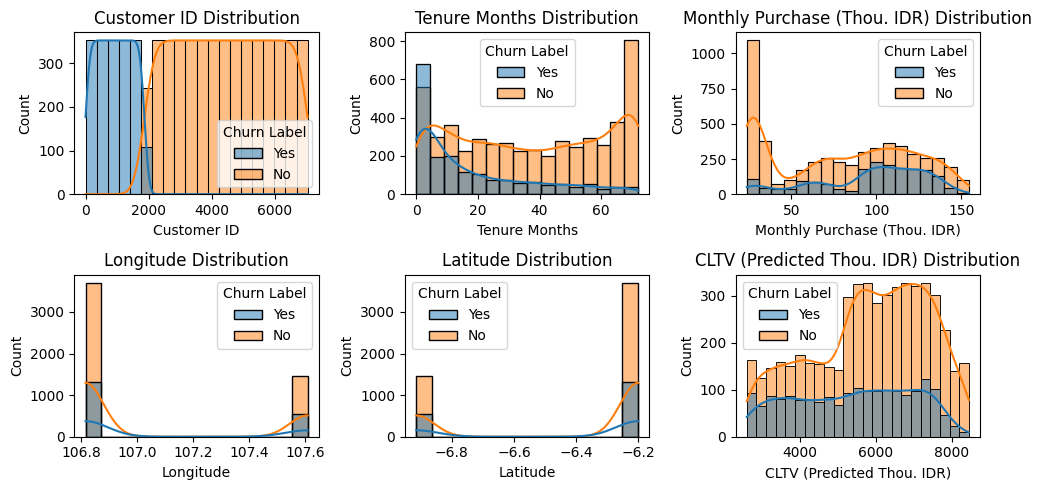

In [123]:
numerical_columns = df.select_dtypes(include=[int, float]).columns
fig, ax = plt.subplots(nrows=int(len(numerical_columns)//3), ncols=3, figsize=(10, 5))

i = 0 # for accessing array of column names
for rows in ax: # access rows of subplots
    for col in rows: # access column inside subplot rows
        sns.histplot(data=df, x=numerical_columns[i], hue="Churn Label", kde=True, ax=col)
        col.set_title(f"{numerical_columns[i]} Distribution")
        i+=1
fig.tight_layout()

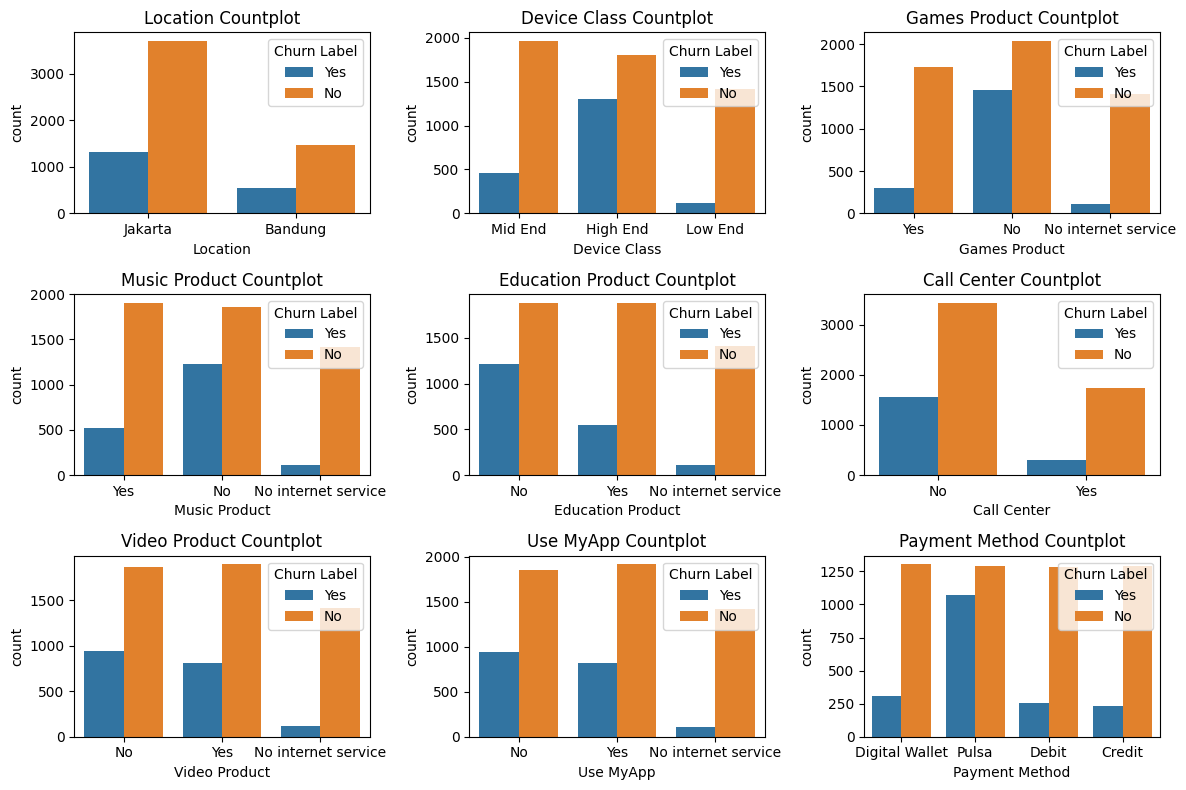

In [124]:
numerical_columns = df.select_dtypes(include=[object]).columns
fig, ax = plt.subplots(nrows=int(len(numerical_columns)//3), ncols=3, figsize=(12, 8))

i = 0 # for accessing array of column names
for rows in ax: # access rows of subplots
    for col in rows: # access column inside subplot rows
        sns.countplot(data=df,x=numerical_columns[i], hue='Churn Label', ax=col)
        col.set_title(f"{numerical_columns[i]} Countplot")
        i+=1
fig.tight_layout()

### Skew

In [125]:
numerical_columns = df.select_dtypes(include=[int, float]).columns
for col in numerical_columns:
    skewness = df[col].skew()
    if skewness < -0.5: 
        print(f"{col}, skewness: {skewness}, left skewed")
    elif skewness > 0.5: 
        print(f"{col}, skewness: {skewness}, right skewed")
    else: 
        print(f"{col}, skewness: {skewness}, approximately symmetric")

Customer ID, skewness: 0.0, approximately symmetric
Tenure Months, skewness: 0.2395397495619829, approximately symmetric
Monthly Purchase (Thou. IDR), skewness: -0.2205244339439807, approximately symmetric
Longitude, skewness: 0.9491054700666193, right skewed
Latitude, skewness: -0.9491054700664001, left skewed
CLTV (Predicted Thou. IDR), skewness: -0.3116021004049805, approximately symmetric


### Kurtosis

In [126]:
numerical_columns = df.select_dtypes(include=[int, float]).columns
for col in numerical_columns:
    kurtosis = df[col].kurtosis()
    if kurtosis > 3:
        print(f"{col}, kurtosis: {kurtosis}, leptokurtic (heavy tailed, more chance of outliers)")
    elif kurtosis < 3:
        print(f"{col}, kurtosis: {kurtosis}, platykurtic")
    else:
        print(f"{col}, kurtosis: {kurtosis}, mesokurtic")

Customer ID, kurtosis: -1.1999999999999997, platykurtic
Tenure Months, kurtosis: -1.3873716359716848, platykurtic
Monthly Purchase (Thou. IDR), kurtosis: -1.2572596945495054, platykurtic
Longitude, kurtosis: -1.099511115413302, platykurtic
Latitude, kurtosis: -1.0995111154135797, platykurtic
CLTV (Predicted Thou. IDR), kurtosis: -0.9340324830072797, platykurtic


## Device Class

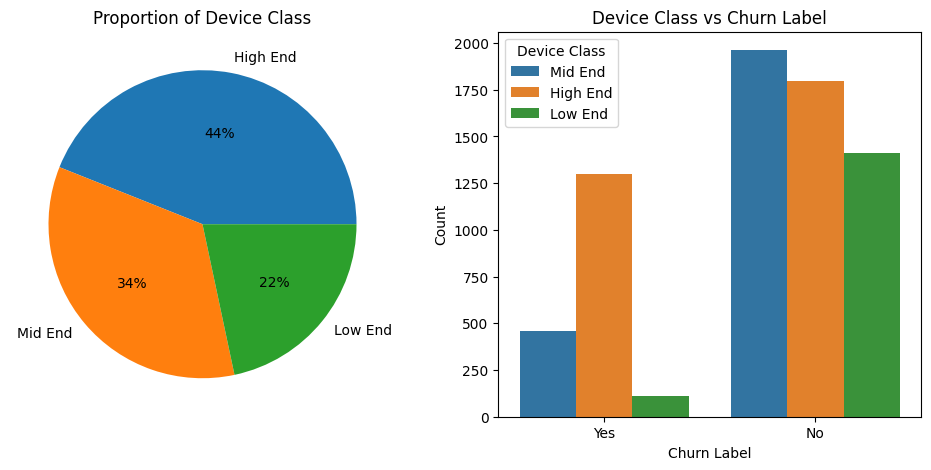

In [127]:
fig, ax = plt.subplots(figsize=(12, 5), ncols=2)

# Proportion of the Device Class
# =================================================================
plot_df = df["Device Class"].value_counts(normalize=True) * 100
ax[0].pie(plot_df, labels=plot_df.index, autopct="%.0f%%")
ax[0].set_title("Proportion of Device Class")

# Device Class vs Churn Label
# =================================================================
sns.countplot(data=df, x='Churn Label', hue='Device Class', ax=ax[1])
ax[1].set(xlabel = "Churn Label", ylabel="Count", title="Device Class vs Churn Label")
plt.show()

1. `~1250` customer who churned are from the high end class followed by mid (`~500`) and low (`~125`) end class. From this data higher end devices resulted in more likely to churn.
2. The proportion is dominated by **High End**, followed by **Mid End** and **Low End**

## Location

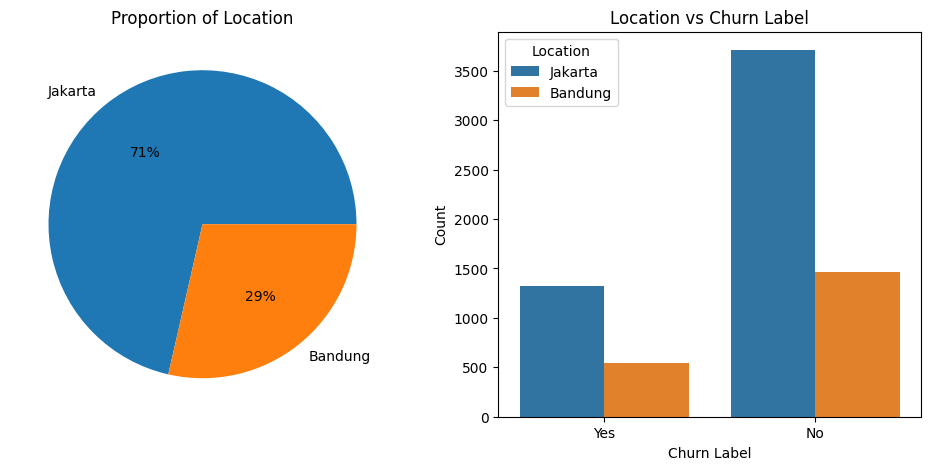

In [128]:
fig, ax = plt.subplots(figsize=(12, 5), ncols=2)

# Proportion of the Location
# =================================================================
plot_df = df["Location"].value_counts(normalize=True) * 100
ax[0].pie(plot_df, labels=plot_df.index, autopct="%.0f%%")
ax[0].set_title("Proportion of Location")

# Location vs Churn Label
# =================================================================
sns.countplot(data=df, x='Churn Label', hue='Location', ax=ax[1])
ax[1].set(xlabel = "Churn Label", ylabel="Count", title="Location vs Churn Label")
plt.show()

In [129]:
location_churn = df.pivot_table(values="Customer ID", index="Churn Label", columns="Location", aggfunc="count", margins=True)
location_churn / location_churn.loc["All", :]

Location,Bandung,Jakarta,All
Churn Label,,,
No,0.728628,0.73703,0.73463
Yes,0.271372,0.26297,0.26537
All,1.000000,1.00000,1.00000


1. Jakarta has the highes churn rate, but It's due to inequality of proportion between users from **Jakarta** and **Bandung**
2. The changes of user either from `Bandung` and `Jakarta` are almost the same. 

## Games Product, Music Product, Education Product, Video Product, and Use MyApp
`No internet service` and `No` means the same thing which is the use doesn't use the internet for the specified **product** or **app**.

In [130]:
# change label of product and app
def preprocess_data(df):
    def check_internet_service(row): 
        if row['Games Product'] == "No internet service"\
            and row['Music Product'] == "No internet service"\
            and row['Education Product'] == "No internet service"\
            and row['Video Product'] == "No internet service"\
            and row['Use MyApp'] == "No internet service":
            return 0
        else: return 1
    
    df=df.copy()
    df['Internet Service'] = df.apply(lambda x: check_internet_service(x), axis=1)
    
    # prod_app_map = {
    #     "Yes": 1,
    #     "No": 0,
    #     "No internet service": 0,
    # }
    # df['Games Product'] = df['Games Product'].replace(prod_app_map)
    # df['Music Product'] = df['Music Product'].replace(prod_app_map)
    # df['Education Product'] = df['Education Product'].replace(prod_app_map)
    # df['Video Product'] = df['Video Product'].replace(prod_app_map)
    # df['Use MyApp'] = df['Use MyApp'].replace(prod_app_map)

    df['Churn'] = df['Churn Label'].map({"Yes": "1", "No": "0"}).astype(int)    
    df['Total Purchase'] = df['Tenure Months'] * df['Monthly Purchase (Thou. IDR)']
    return df

df = preprocess_data(df_ori)

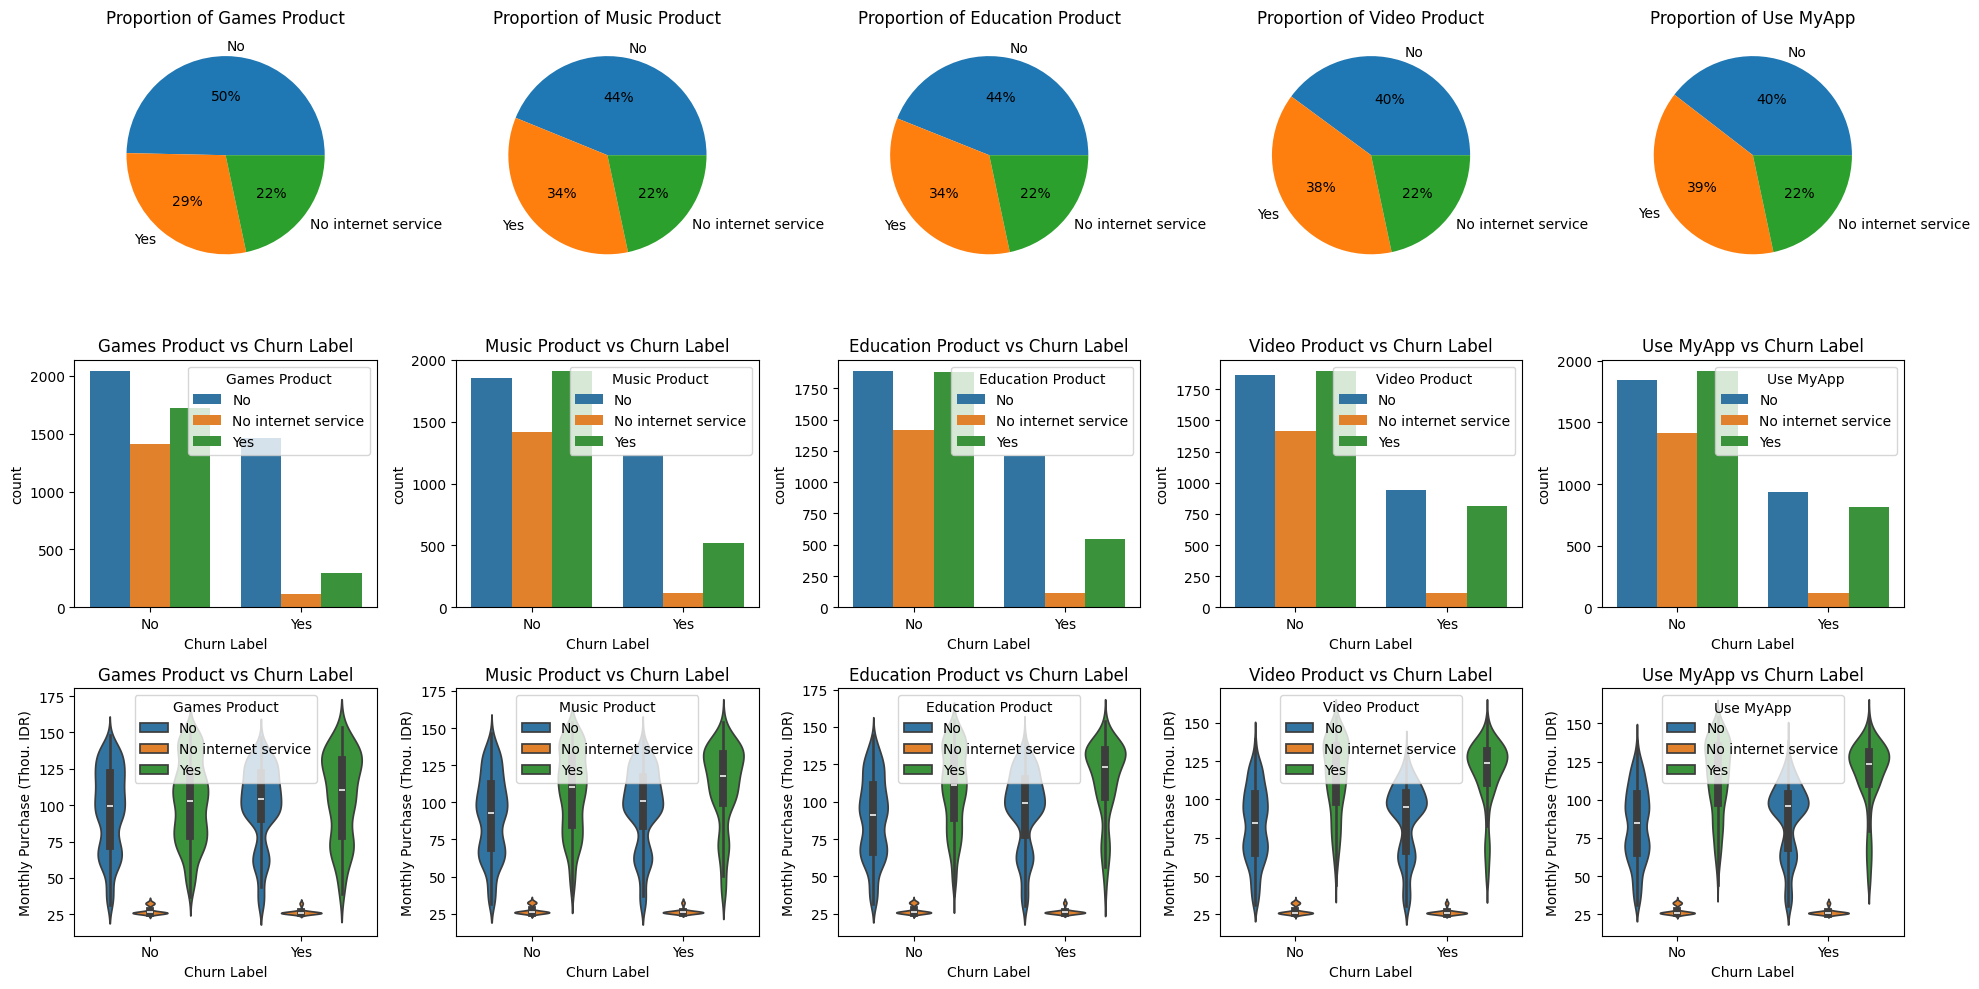

In [131]:

cols = ["Games Product", "Music Product", "Education Product", "Video Product", "Use MyApp"]
fig, ax = plt.subplots(nrows=3, ncols=len(cols), figsize=(20, 10))

for i, c in enumerate(cols):
    plot_df = df[c].value_counts(normalize=True) * 100
    ax[0][i].pie(plot_df, labels=plot_df.index, autopct="%.0f%%")
    ax[0][i].set_title(f"Proportion of {c}")
    

for i, c in enumerate(cols):
    sns.countplot(data=df.sort_values(by=[c, 'Churn Label']), x='Churn Label', hue=c, ax=ax[1][i])
    ax[1][i].set_title(f"{c} vs Churn Label")
    
    
for i, c in enumerate(cols):
    sns.violinplot(data=df.sort_values(by=[c, 'Churn Label']), x='Churn Label', y="Monthly Purchase (Thou. IDR)", hue=c, ax=ax[2][i])
    ax[2][i].set_title(f"{c} vs Churn Label")

fig.tight_layout()

1. People who didn't use internet service for Games, Music, and Education Product has a higher change of churn.
2. People who's monthly purchase is around **100K** and didn't use the internet service for any of the products has more change of churning
3. People who's monthly purchase is around **125K** and didn't use the internet service for any of the products has more change of churning

Users who churned they don't use the internet service for accessing those products

## Payment Method

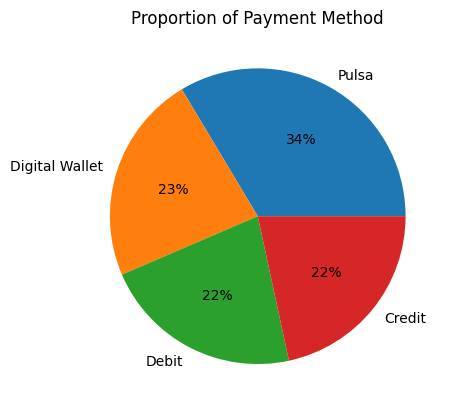

In [132]:
plot_df = df["Payment Method"].value_counts(normalize=True) * 100
plt.pie(plot_df, labels=plot_df.index, autopct="%.0f%%")
plt.title(f"Proportion of Payment Method")
plt.show()

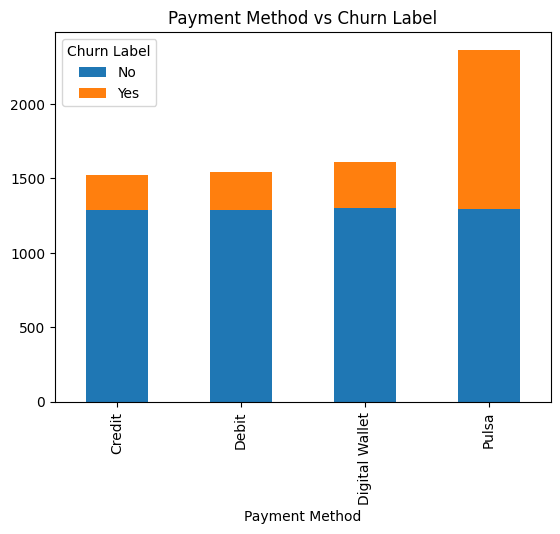

In [133]:
plot_df = df.pivot_table(index="Payment Method", columns="Churn Label", values="Customer ID", aggfunc="count")
plot_df.plot(kind="bar", stacked=True)
plt.title("Payment Method vs Churn Label")
plt.show()

In [134]:
churn_payment_method = df.pivot_table(index="Payment Method", columns="Churn", values="Customer ID", aggfunc="count", margins=True)
churn_payment_method /= churn_payment_method.loc['All', :]
churn_payment_method = churn_payment_method.loc[churn_payment_method.index != 'All', churn_payment_method.columns != 'All']
churn_payment_method

Churn,0,1
Payment Method,,
Credit,0.249324,0.124131
Debit,0.248550,0.138042
Digital Wallet,0.252029,0.164794
Pulsa,0.250097,0.573034


1. Users buy using pulsa has high change of churn

## Tenure Months

In [135]:
df.pivot_table(index="Churn", values="Tenure Months", aggfunc="mean")

,Tenure Months
Churn,
0,37.569965
1,17.979133


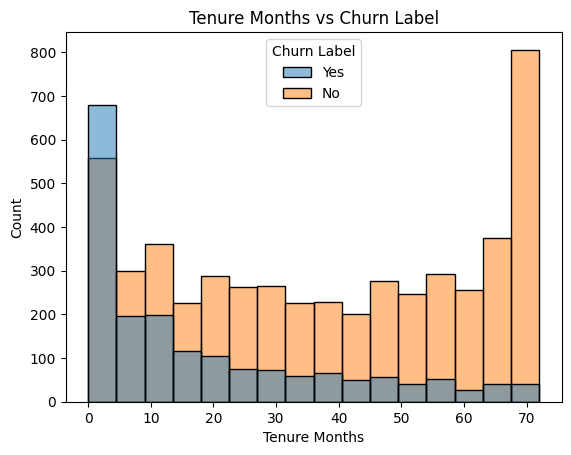

In [136]:
sns.histplot(data=df, x='Tenure Months', hue='Churn Label')
plt.title("Tenure Months vs Churn Label")
plt.show()

User with low tenure has a high change of churning especially from 0 to 10 months tenure

## Monthly Purchase

In [137]:
df.pivot_table(index="Churn", values="Monthly Purchase (Thou. IDR)", aggfunc="mean")

,Monthly Purchase (Thou. IDR)
Churn,
0,79.644661
1,96.773732


Users churn because of monthly payment that they have to spend is more than the un-churned. But does it make sense. Let's take a look at the distribution

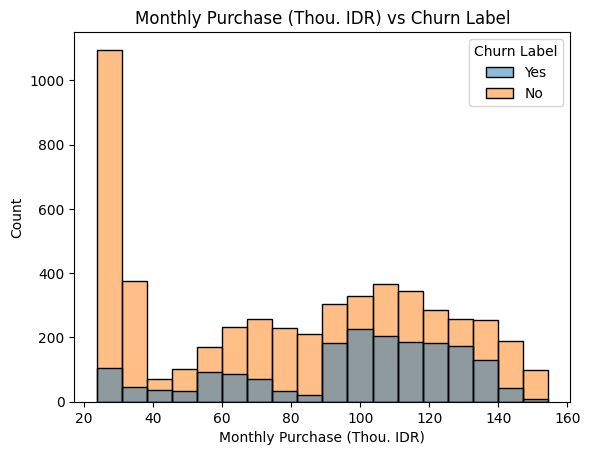

In [138]:
sns.histplot(data=df, x="Monthly Purchase (Thou. IDR)", hue="Churn Label")
plt.title("Monthly Purchase (Thou. IDR) vs Churn Label")
plt.show()

Customer also churned for low monhtly purchases, but mose of the churned users spend between Rp 100,000.00 - Rp 120,000.00 a month.

## CLTV

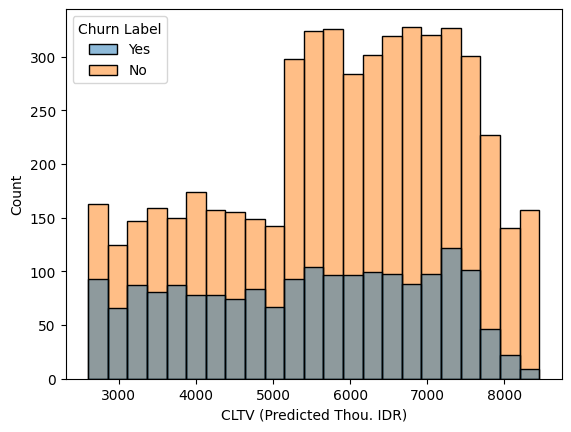

In [139]:
sns.histplot(data=df, x='CLTV (Predicted Thou. IDR)', hue='Churn Label')
plt.show()
plt.show()

CLTV can't be used as a feature because CLTV are normally distributed for all churned users, hence it is not a strong feature. The CLTV above Rp 7,500,000 has a high chance of churning.

## Call Center
Check whether the customer uses the call center service

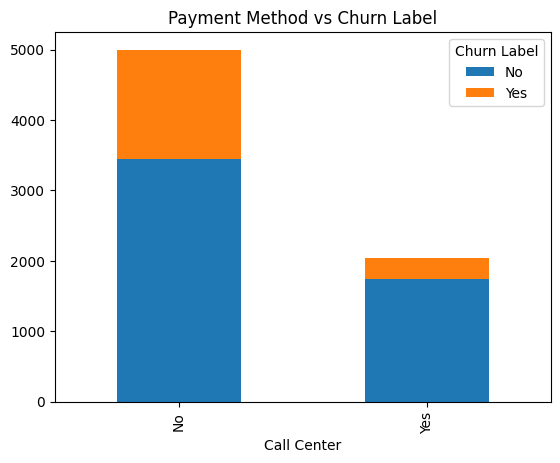

In [140]:
plot_df = df.pivot_table(index="Call Center", columns="Churn Label", values="Customer ID", aggfunc="count")
plot_df.plot(kind="bar", stacked=True)
plt.title("Payment Method vs Churn Label")
plt.show()

## Total Purchase

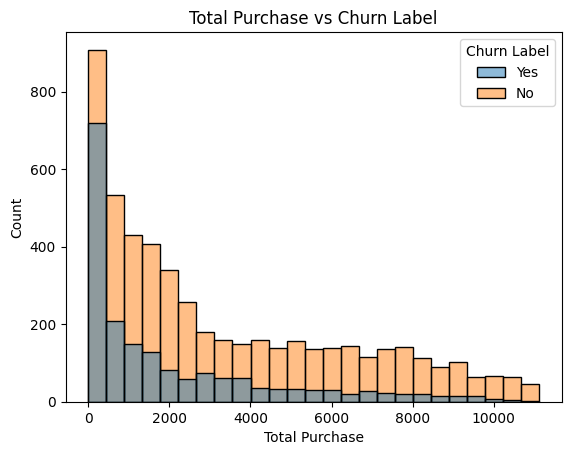

In [141]:
sns.histplot(data=df, x="Total Purchase", hue="Churn Label")
plt.title("Total Purchase vs Churn Label")
plt.show()

Really hard to tell based on the Total 

In [142]:
df

,Customer ID,Tenure Months,Location,Device Class,Games Product,Music Product,Education Product,Call Center,Video Product,Use MyApp,Payment Method,Monthly Purchase (Thou. IDR),Churn Label,Longitude,Latitude,CLTV (Predicted Thou. IDR),Internet Service,Churn,Total Purchase
0,0,2,Jakarta,Mid End,Yes,Yes,No,No,No,No,Digital Wallet,70.005,Yes,106.816666,-6.2,4210.7,1,1,140.01
1,1,2,Jakarta,High End,No,No,No,No,No,No,Pulsa,91.910,Yes,106.816666,-6.2,3511.3,1,1,183.82
2,2,8,Jakarta,High End,No,No,Yes,No,Yes,Yes,Pulsa,129.545,Yes,106.816666,-6.2,6983.6,1,1,1036.36
3,3,28,Jakarta,High End,No,No,Yes,Yes,Yes,Yes,Pulsa,136.240,Yes,106.816666,-6.2,6503.9,1,1,3814.72
4,4,49,Jakarta,High End,No,Yes,Yes,No,Yes,Yes,Debit,134.810,Yes,106.816666,-6.2,6942.0,1,1,6605.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,7038,72,Jakarta,Low End,No internet service,No internet service,No internet service,No,No internet service,No internet service,Debit,27.495,No,106.816666,-6.2,6897.8,0,0,1979.64
7039,7039,24,Jakarta,Mid End,Yes,No,Yes,Yes,Yes,Yes,Digital Wallet,110.240,No,106.816666,-6.2,2782.0,1,0,2645.76
7040,7040,72,Jakarta,High End,No,Yes,Yes,No,Yes,Yes,Credit,134.160,No,106.816666,-6.2,7228.0,1,0,9659.52
7041,7041,11,Jakarta,Mid End,Yes,No,No,No,No,No,Pulsa,38.480,No,106.816666,-6.2,3630.9,1,0,423.28


## Used Products

<function matplotlib.pyplot.show(close=None, block=None)>

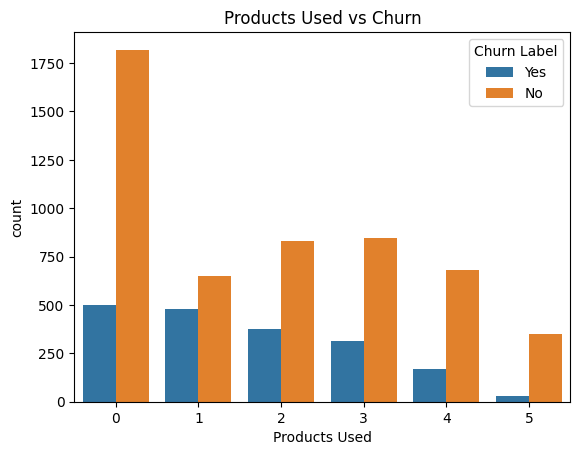

In [143]:
def uses_internet_for_product(data):
    if data == "Yes": 
        return 1
    return 0

# Total Product Used
df["Products Used"] = df[['Games Product', 'Music Product', 'Education Product', 'Video Product', 'Use MyApp']]\
    .apply(lambda x: uses_internet_for_product(x['Games Product'])
        + uses_internet_for_product(x['Music Product'])
        + uses_internet_for_product(x['Education Product'])
        + uses_internet_for_product(x['Video Product'])
        + uses_internet_for_product(x['Use MyApp']), axis=1)

sns.countplot(data=df, x="Products Used", hue="Churn Label")
plt.title("Products Used vs Churn")
plt.show

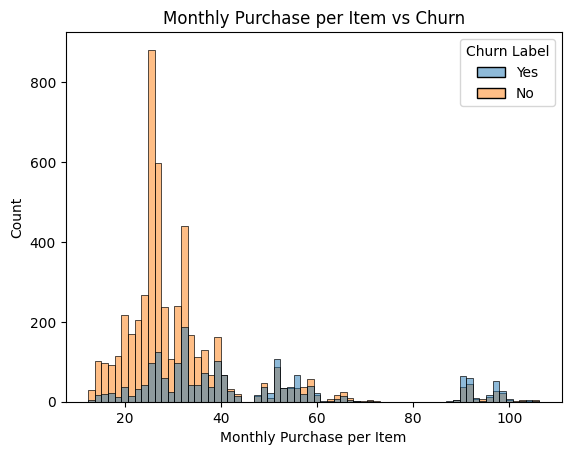

In [146]:
df["Monthly Purchase per Item"] = df["Monthly Purchase (Thou. IDR)"] / (df["Products Used"]+1)

sns.histplot(data=df, x="Monthly Purchase per Item", hue="Churn Label")
plt.title("Monthly Purchase per Item vs Churn")
plt.show()

User that pay more and use little of the product services has a high chance of churning

## Correlation Map

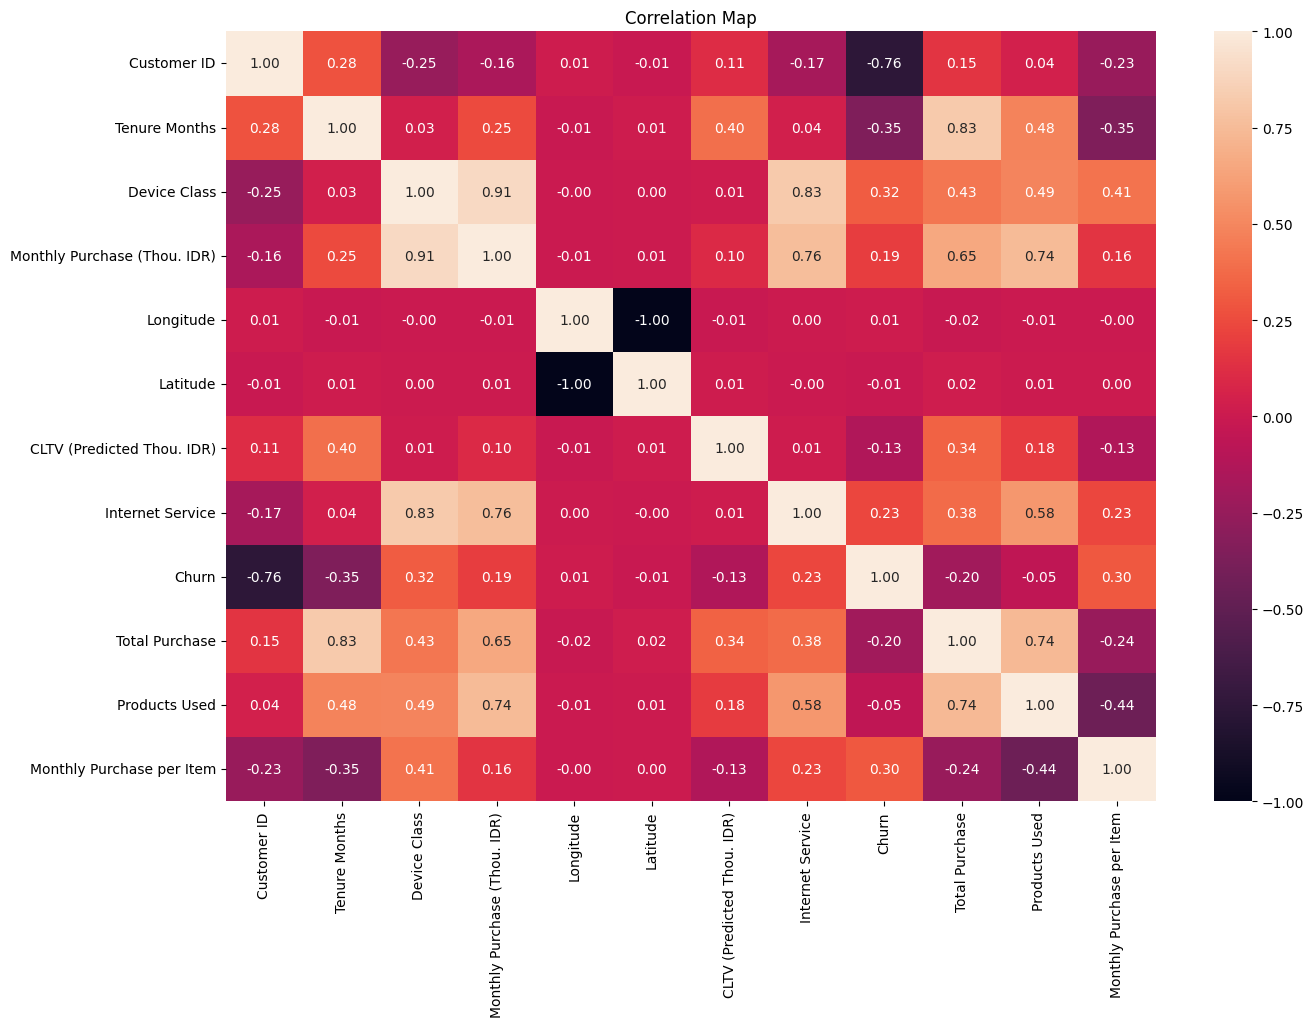

In [147]:
device_class_map = {
    "High End": 3,
    "Mid End": 2,
    "Low End": 1
}
df["Device Class"] = df["Device Class"].replace(device_class_map)
corr = df.select_dtypes([int, float]).corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr, annot=True, fmt=".2f")
plt.title("Correlation Map")
plt.show()

# Modelling

In [238]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# imports
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score, roc_curve, accuracy_score
from imblearn.metrics import specificity_score
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit

# machine learning model
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier, 
    RandomForestClassifier,
    ExtraTreesClassifier,
    GradientBoostingClassifier,
)
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (recall_score, precision_score, f1_score, roc_auc_score)
from sklearn.model_selection import (train_test_split, StratifiedShuffleSplit, cross_val_score)
from sklearn.preprocessing import StandardScaler
import catboost as cb
import xgboost as xgb
import lightgbm as lgb


# oversampling
from imblearn.over_sampling import (
    RandomOverSampler,
    SMOTE, 
    BorderlineSMOTE,
    SVMSMOTE
)

# hyperparameter tuning
import optuna

In [239]:
def evaluate(model, y_true, y_pred, y_pred_proba):
    """
        Evaluate model performance
    """
    print(f"""
    METRICS
    Accuracy: {accuracy_score(y_true, y_pred)}
    Precision: {precision_score(y_true, y_pred)}
    Recall: {recall_score(y_true, y_pred)}
    F1 Score: {f1_score(y_true, y_pred)}
    ROC AUC score: {roc_auc_score(y_true, y_pred)}
    Specificity: {specificity_score(y_true, y_pred)}
    """)

    # confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=model.classes_)
    display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    display.plot()
    plt.title(f"Confusion Matrix of {model.__class__.__name__}")
    plt.show()

    # ROC curve plot
    fpr, tpr, _ = roc_curve(y_true,  y_pred_proba[:, -1])
    plt.plot(fpr, tpr)
    plt.plot((0, 1), (0, 1))
    plt.title("ROC Curve")
    plt.show()

## Baseline Model AKA. Dummy Classifier


    METRICS
    Accuracy: 0.6132008516678495
    Precision: 0.27676240208877284
    Recall: 0.28342245989304815
    F1 Score: 0.28005284015852044
    ROC AUC score: 0.5078948048257511
    Specificity: 0.7323671497584541
    


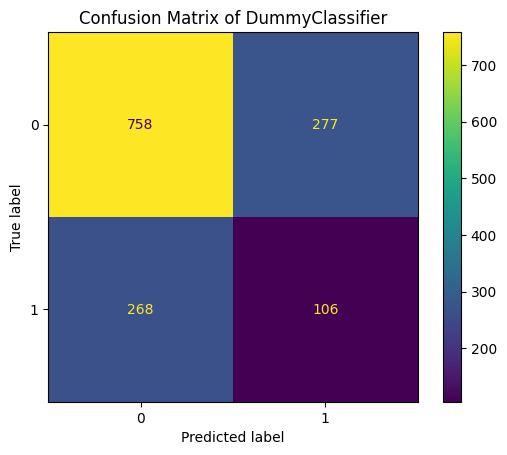

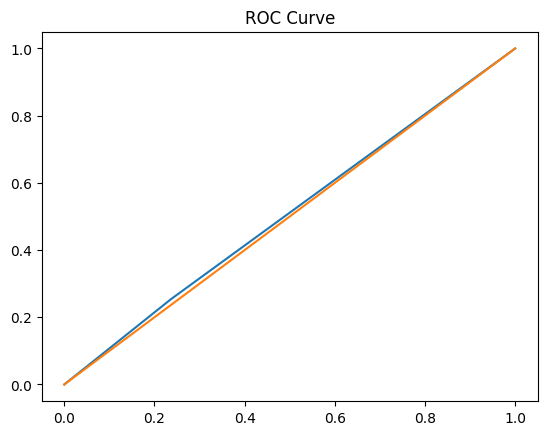

In [240]:
# Data Preparation
# ==============================================
df = df_ori.copy()
df["Device Class"] = df["Device Class"].replace({"High End": 3, "Mid End": 2, "Low End": 1})  # encode Device Class  
df['Churn Label'] = df['Churn Label'].replace({"Yes": 1, "No": 0})  # encode Churn Label
df = df.drop(columns=["Customer ID", "Location", "Longitude", "Latitude", "CLTV (Predicted Thou. IDR)"])  # drop unimportant data
X, y = pd.get_dummies(df.drop(columns=["Churn Label"]), dtype=int), df["Churn Label"]  # split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

# Train Dummy Classifier
# ==============================================
model = DummyClassifier(strategy="stratified")
model.fit(X_train, y_train)

# Predict using Dummy Classifier
# ==============================================
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

# Evaluate Model
# ==============================================
evaluate(model, y_test, y_pred, y_pred_proba)

## Model Improvement

### Using Different Model

[0.50501672 0.5451505  0.52173913 0.56521739 0.48160535] 
Score Mean: 0.5237458193979933

    METRICS
    Accuracy: 0.7906316536550745
    Precision: 0.6321070234113713
    Recall: 0.5053475935828877
    F1 Score: 0.5616641901931649
    ROC AUC score: 0.6995337001730864
    Specificity: 0.893719806763285
    


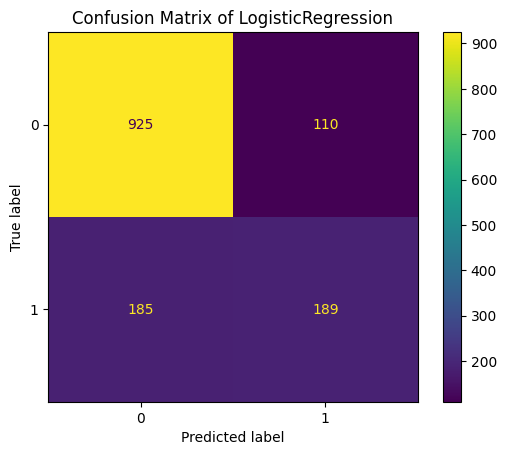

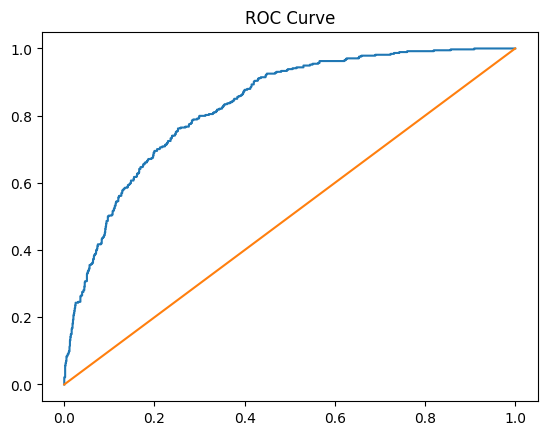

In [241]:
# Data Preparation
# ==============================================
df = df_ori.copy()
df["Device Class"] = df["Device Class"].replace({"High End": 3, "Mid End": 2, "Low End": 1})  # encode Device Class  
df['Churn Label'] = df['Churn Label'].replace({"Yes": 1, "No": 0})  # encode Churn Label
df = df.drop(columns=["Customer ID", "Location", "Longitude", "Latitude", "CLTV (Predicted Thou. IDR)"])  # drop unimportant data
X, y = pd.get_dummies(df.drop(columns=["Churn Label"]), dtype=int), df["Churn Label"]  # split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

# Cross Validation
# ========================================
model = LogisticRegression(random_state=42, max_iter=500)  # <<<<<<<<<<<<< DIFFERENT MODEL
cv = StratifiedShuffleSplit(n_splits=5,  test_size=0.2, random_state=42)
score = cross_val_score(model, X_train, y_train, cv=cv, scoring='recall')
print(score, f"\nScore Mean: {score.mean()}")


# Train Classifier
# ==============================================
model = LogisticRegression(random_state=42, max_iter=500)
model.fit(X_train, y_train)

# Predict using Classifier
# ==============================================
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

# Evaluate Model
# ==============================================
evaluate(model, y_test, y_pred, y_pred_proba)

1. We improve the specificity rate of predicting the negative class from **ground truth negative class**.
2. However we need to improve more on the recall and precision.

Model improve just a little

### Feature Engineering

In [242]:
# function for feature engineering
def check_internet_service(row): 
    if row['Games Product'] == "No internet service"\
        and row['Music Product'] == "No internet service"\
        and row['Education Product'] == "No internet service"\
        and row['Video Product'] == "No internet service"\
        and row['Use MyApp'] == "No internet service":
        return 0
    else: return 1

def uses_internet_for_product(data):
    if data == "Yes": 
        return 1
    return 0

[0.5083612  0.5451505  0.52173913 0.55852843 0.48494983 0.51505017
 0.56521739 0.50501672 0.50167224 0.53177258] 
Score Mean: 0.5237458193979934

    METRICS
    Accuracy: 0.7963094393186657
    Precision: 0.6445182724252492
    Recall: 0.5187165775401069
    F1 Score: 0.5748148148148149
    ROC AUC score: 0.7076674675140148
    Specificity: 0.8966183574879227
    


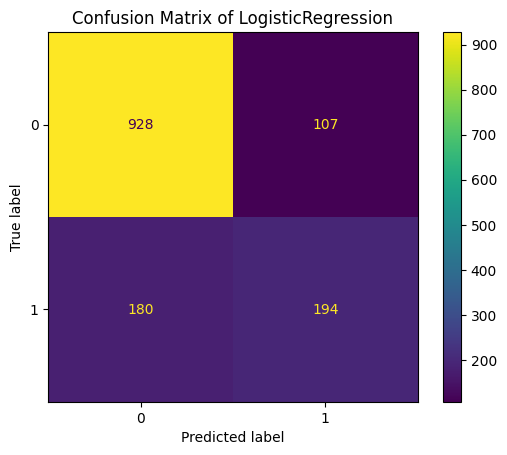

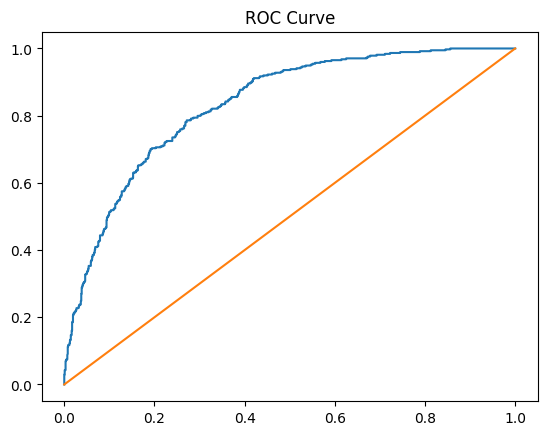

In [243]:
# Data Preparation
# ==============================================
df = df_ori.copy()
df["Internet Service"] = df.apply(lambda x: check_internet_service(x), axis=1)  # feature engineering
df["Device Class"] = df["Device Class"].replace({"High End": 3, "Mid End": 2, "Low End": 1})  # encode Device Class
df["Churn Label"] = df["Churn Label"].replace({"Yes": 1, "No": 0})  # encode Churn Label
df["Products Used"] = df[["Games Product", "Music Product", "Education Product", "Video Product", "Use MyApp"]]\
    .apply(lambda x: uses_internet_for_product(x["Games Product"])
        + uses_internet_for_product(x["Music Product"])
        + uses_internet_for_product(x["Education Product"])
        + uses_internet_for_product(x["Video Product"])
        + uses_internet_for_product(x["Use MyApp"]), axis=1)
df["Monthly Purchase Per Item"] = df[["Monthly Purchase (Thou. IDR)", "Products Used"]]\
    .apply(lambda x: x["Monthly Purchase (Thou. IDR)"] / x["Products Used"] if x["Products Used"] > 0 else x["Monthly Purchase (Thou. IDR)"], axis=1)
df["Total Purchase"] = df["Tenure Months"] * df["Monthly Purchase (Thou. IDR)"]  # feature engineering
df["Total Purchase Per Item"] = df["Tenure Months"] * df["Monthly Purchase Per Item"]  # feature engineering
df = df.drop(columns=["Customer ID", "Location", "Longitude", "Latitude", "CLTV (Predicted Thou. IDR)", "Products Used"])  # drop unimportant data


X, y = pd.get_dummies(df.drop(columns=["Churn Label"]), dtype=int), df["Churn Label"]  # split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

# Scale data
# ========================================
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # <<<<<<<<<<<<< SCALING
X_test = scaler.transform(X_test)  # <<<<<<<<<<<<< SCALING

# Cross Validation
# ========================================
model = LogisticRegression(random_state=42, max_iter=200)  # <<<<<<<<<<<<< DIFFERENT MODEL
cv = StratifiedShuffleSplit(n_splits=10,  test_size=0.2, random_state=42)
score = cross_val_score(model, X_train, y_train, cv=cv, scoring="recall")
print(score, f"\nScore Mean: {score.mean()}")

# Train Dummy Classifier
# ==============================================
model = LogisticRegression(random_state=42, max_iter=200)
model.fit(X_train, y_train)

# Predict using Dummy Classifier
# ==============================================
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

# Evaluate Model
# ==============================================
evaluate(model, y_test, y_pred, y_pred_proba)

Exist some multicllinearity between Total Purchases with CLTV, Tenure Months, Monthly Purchase and Device Classes. Let's try to perform PCA on it

### Try Other Models

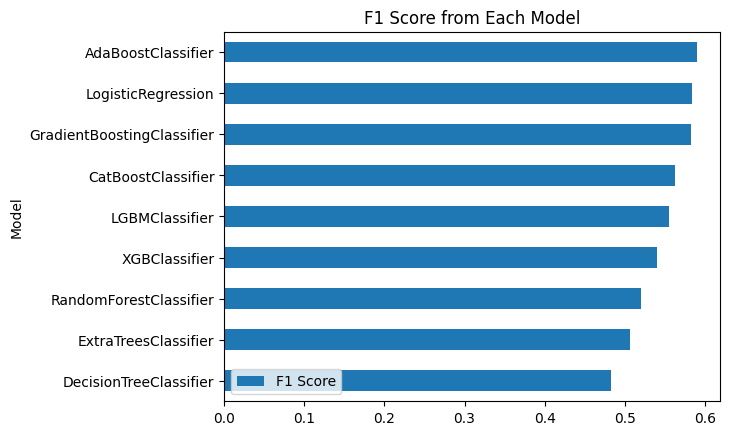

In [176]:
models = [
    LogisticRegression(random_state=42, max_iter=200), 
    DecisionTreeClassifier(random_state=42), 
    RandomForestClassifier(random_state=42), 
    AdaBoostClassifier(random_state=42), 
    GradientBoostingClassifier(random_state=42), 
    xgb.XGBClassifier(random_state=42),
    cb.CatBoostClassifier(random_state=42), 
    lgb.LGBMClassifier(objective='binary', random_state=42), 
    ExtraTreesClassifier(random_state=42)
]

recalls = []
precisions = []
f1s = []
roc_aucs = []

for model in models:
    # Data Preparation
    # ==============================================
    df = df_ori.copy()
    df["Internet Service"] = df.apply(lambda x: check_internet_service(x), axis=1)  # feature engineering
    df["Device Class"] = df["Device Class"].replace({"High End": 3, "Mid End": 2, "Low End": 1})  # encode Device Class
    df["Churn Label"] = df["Churn Label"].replace({"Yes": 1, "No": 0})  # encode Churn Label
    df["Products Used"] = df[["Games Product", "Music Product", "Education Product", "Video Product", "Use MyApp"]]\
        .apply(lambda x: uses_internet_for_product(x["Games Product"])
            + uses_internet_for_product(x["Music Product"])
            + uses_internet_for_product(x["Education Product"])
            + uses_internet_for_product(x["Video Product"])
            + uses_internet_for_product(x["Use MyApp"]), axis=1)
    df["Monthly Purchase Per Item"] = df[["Monthly Purchase (Thou. IDR)", "Products Used"]]\
        .apply(lambda x: x["Monthly Purchase (Thou. IDR)"] / x["Products Used"] if x["Products Used"] > 0 else x["Monthly Purchase (Thou. IDR)"], axis=1)
    df["Total Purchase"] = df["Tenure Months"] * df["Monthly Purchase (Thou. IDR)"]  # feature engineering
    df["Total Purchase Per Item"] = df["Tenure Months"] * df["Monthly Purchase Per Item"]  # feature engineering
    df = df.drop(columns=["Customer ID", "Location", "Longitude", "Latitude", "CLTV (Predicted Thou. IDR)", "Products Used"])  # drop unimportant data
    X, y = pd.get_dummies(df.drop(columns=["Churn Label"]), dtype=int), df["Churn Label"]  # split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

    # Scale data
    # ========================================
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)  # <<<<<<<<<<<<< SCALING
    X_test = scaler.transform(X_test)  # <<<<<<<<<<<<< SCALING
    
    # Cross Validation
    # ========================================
    cv = StratifiedShuffleSplit(n_splits=5,  test_size=0.2, random_state=42)
    score = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1')
    f1s.append(score.mean())
    print(f"{model.__class__.__name__} done")

    
df_model = pd.DataFrame(
    {
        "Model": [model.__class__.__name__ for model in models],
        "F1 Score": f1s,
    }
).set_index("Model")

# plot the f1 score comparison
df_model.sort_values(by="F1 Score").plot.barh()
plt.title("F1 Score from Each Model")
plt.legend(loc="lower left")
plt.show()

Best Models
1. AdaBoostClassifier **(took to long)**
2. Logistic Regression
3. GradientBoostingClassifier **(took to long)**
4. CatBoostClassifier
5. LGBMClassifier
6. XGBClassifier

In [188]:
# Data Preparation
# ==============================================
df = df_ori.copy()
df["Internet Service"] = df.apply(lambda x: check_internet_service(x), axis=1)  # feature engineering
df["Device Class"] = df["Device Class"].replace({"High End": 3, "Mid End": 2, "Low End": 1})  # encode Device Class
df["Churn Label"] = df["Churn Label"].replace({"Yes": 1, "No": 0})  # encode Churn Label
df["Products Used"] = df[["Games Product", "Music Product", "Education Product", "Video Product", "Use MyApp"]]\
    .apply(lambda x: uses_internet_for_product(x["Games Product"])
        + uses_internet_for_product(x["Music Product"])
        + uses_internet_for_product(x["Education Product"])
        + uses_internet_for_product(x["Video Product"])
        + uses_internet_for_product(x["Use MyApp"]), axis=1)
df["Monthly Purchase Per Item"] = df[["Monthly Purchase (Thou. IDR)", "Products Used"]]\
    .apply(lambda x: x["Monthly Purchase (Thou. IDR)"] / x["Products Used"] if x["Products Used"] > 0 else x["Monthly Purchase (Thou. IDR)"], axis=1)
df["Total Purchase"] = df["Tenure Months"] * df["Monthly Purchase (Thou. IDR)"]  # feature engineering
df["Total Purchase Per Item"] = df["Tenure Months"] * df["Monthly Purchase Per Item"]  # feature engineering
df = df.drop(columns=["Customer ID", "Location", "Longitude", "Latitude", "CLTV (Predicted Thou. IDR)", "Products Used"])  # drop unimportant data
X, y = pd.get_dummies(df.drop(columns=["Churn Label"]), dtype=int), df["Churn Label"]  # split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

# Scale data
# ========================================
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # <<<<<<<<<<<<< SCALING
X_test = scaler.transform(X_test)  # <<<<<<<<<<<<< SCALING

### Perform Oversampling and Predict using Best Models
Oversampling is used to tackle imbalance class problem

In [193]:
# Data Preparation
# ==============================================
df = df_ori.copy()
df["Internet Service"] = df.apply(lambda x: check_internet_service(x), axis=1)  # feature engineering
df["Device Class"] = df["Device Class"].replace({"High End": 3, "Mid End": 2, "Low End": 1})  # encode Device Class
df["Churn Label"] = df["Churn Label"].replace({"Yes": 1, "No": 0})  # encode Churn Label
df["Products Used"] = df[["Games Product", "Music Product", "Education Product", "Video Product", "Use MyApp"]]\
    .apply(lambda x: uses_internet_for_product(x["Games Product"])
        + uses_internet_for_product(x["Music Product"])
        + uses_internet_for_product(x["Education Product"])
        + uses_internet_for_product(x["Video Product"])
        + uses_internet_for_product(x["Use MyApp"]), axis=1)
df["Monthly Purchase Per Item"] = df[["Monthly Purchase (Thou. IDR)", "Products Used"]]\
    .apply(lambda x: x["Monthly Purchase (Thou. IDR)"] / x["Products Used"] if x["Products Used"] > 0 else x["Monthly Purchase (Thou. IDR)"], axis=1)
df["Total Purchase"] = df["Tenure Months"] * df["Monthly Purchase (Thou. IDR)"]  # feature engineering
df["Total Purchase Per Item"] = df["Tenure Months"] * df["Monthly Purchase Per Item"]  # feature engineering
df = df.drop(columns=["Customer ID", "Location", "Longitude", "Latitude", "CLTV (Predicted Thou. IDR)", "Products Used"])  # drop unimportant data
X, y = pd.get_dummies(df.drop(columns=["Churn Label"]), dtype=int), df["Churn Label"]  # split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)


# Scale data
# ========================================
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # <<<<<<<<<<<<< SCALING
X_test = scaler.transform(X_test)  # <<<<<<<<<<<<< SCALING

oversamplers = []
models = []
recalls = []
precisions = [] 
f1_scores = []
roc_aucs = []

for oversampler in [
        RandomOverSampler(random_state = 42),
        SMOTE(random_state = 42),
        BorderlineSMOTE(random_state = 42),
        SVMSMOTE(random_state = 42),
    ]:
    for model in [
        LogisticRegression(random_state=42, max_iter=200), 
        xgb.XGBClassifier(random_state=42),
        cb.CatBoostClassifier(random_state=42, verbose=0), 
        lgb.LGBMClassifier(objective='binary', random_state=42), 
    ]:
        # Cross Validation
        # ========================================
        # model = LogisticRegression(random_state=42, max_iter=200)
        cv = StratifiedShuffleSplit(n_splits=5,  test_size=0.2, random_state=42)
        recall = cross_val_score(model, X_train, y_train, cv=cv, scoring="recall")
        precision = cross_val_score(model, X_train, y_train, cv=cv, scoring="precision")
        f1 = cross_val_score(model, X_train, y_train, cv=cv, scoring="f1")
        roc_auc = cross_val_score(model, X_train, y_train, cv=cv, scoring="roc_auc")
        
        # Document The Result
        # ========================================
        oversamplers.append(oversampler.__class__.__name__)
        models.append(model.__class__.__name__)
        recalls.append(recall.mean())
        precisions.append(precision.mean())
        f1_scores.append(f1.mean())
        roc_aucs.append(roc_auc.mean())
        print(f"{oversampler.__class__.__name__}, {model.__class__.__name__} done")

result_df = pd.DataFrame({
    "Oversampler": oversamplers,
    "Model": models,
    "Recall": recalls,
    "Precision": precisions,
    "F1 Score": f1_scores,
    "ROC AUC": roc_aucs,
})

result_df

RandomOverSampler, LogisticRegression done
RandomOverSampler, XGBClassifier done
RandomOverSampler, CatBoostClassifier done
[LightGBM] [Info] Number of positive: 1196, number of negative: 3311
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000926 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1164
[LightGBM] [Info] Number of data points in the train set: 4507, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265365 -> initscore=-1.018268
[LightGBM] [Info] Start training from score -1.018268
[LightGBM] [Info] Number of positive: 1196, number of negative: 3311
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000252 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bi

,Oversampler,Model,Recall,Precision,F1 Score,ROC AUC
0,RandomOverSampler,LogisticRegression,0.523746,0.660205,0.583431,0.839576
1,RandomOverSampler,XGBClassifier,0.496321,0.594618,0.540805,0.811344
2,RandomOverSampler,CatBoostClassifier,0.503679,0.638681,0.562779,0.836930
3,RandomOverSampler,LGBMClassifier,0.501672,0.622474,0.555258,0.824796
4,SMOTE,LogisticRegression,0.523746,0.660205,0.583431,0.839576
5,SMOTE,XGBClassifier,0.496321,0.594618,0.540805,0.811344
6,SMOTE,CatBoostClassifier,0.503679,0.638681,0.562779,0.836930
7,SMOTE,LGBMClassifier,0.501672,0.622474,0.555258,0.824796
8,BorderlineSMOTE,LogisticRegression,0.523746,0.660205,0.583431,0.839576
9,BorderlineSMOTE,XGBClassifier,0.496321,0.594618,0.540805,0.811344


C:\Users\923006079\AppData\Local\Temp\ipykernel_7712\187240413.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(labels=plot_df["Model"], rotation=45)
C:\Users\923006079\AppData\Local\Temp\ipykernel_7712\187240413.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(labels=plot_df["Model"], rotation=45)
C:\Users\923006079\AppData\Local\Temp\ipykernel_7712\187240413.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(labels=plot_df["Model"], rotation=45)
C:\Users\923006079\AppData\Local\Temp\ipykernel_7712\187240413.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabel

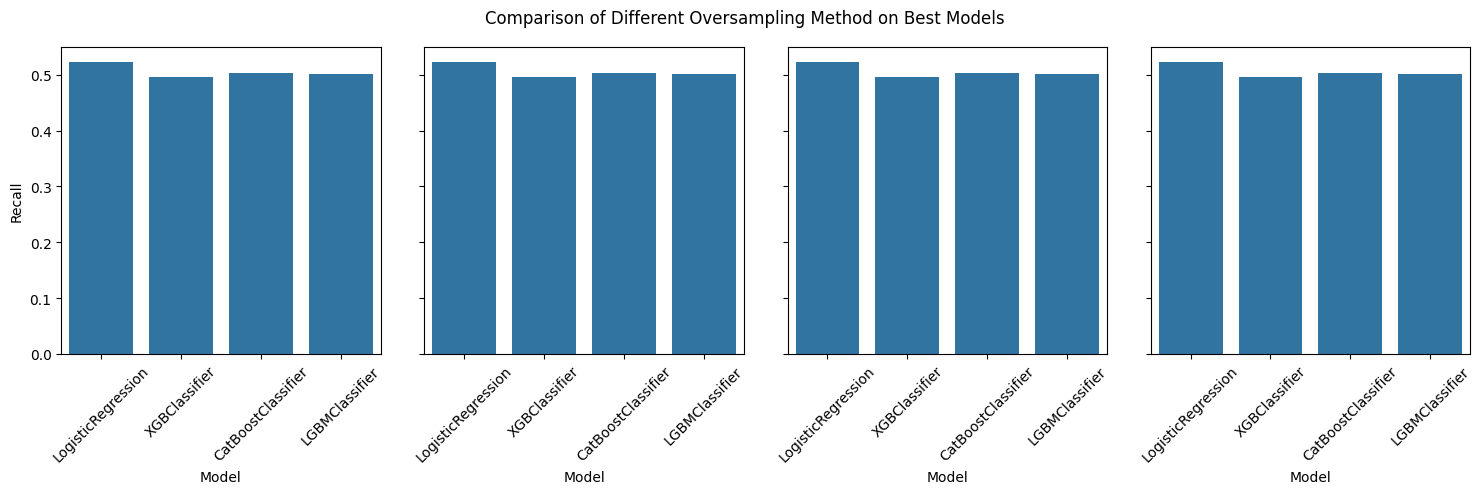

In [215]:
fig, ax = plt.subplots(ncols=4, figsize=(15, 5), sharey=True)
for i, oversampler in enumerate(
    [
        "RandomOverSampler",
        "SMOTE",
        "BorderlineSMOTE",
        "SVMSMOTE"
    ]
    ):
    plot_df = result_df[result_df["Oversampler"]==oversampler]
    sns.barplot(data=plot_df, x="Model", y="Recall", ax=ax[i])
    ax[i].set_xticklabels(labels=plot_df["Model"], rotation=45)
fig.suptitle("Comparison of Different Oversampling Method on Best Models")
fig.tight_layout()

Best performing oversampling method based on f1 score

# Hyperparameter Tuning

## Logistic Regression

In [212]:
# Data Preparation
# ==============================================
df = df_ori.copy()
df["Internet Service"] = df.apply(lambda x: check_internet_service(x), axis=1)  # feature engineering
df["Device Class"] = df["Device Class"].replace({"High End": 3, "Mid End": 2, "Low End": 1})  # encode Device Class
df["Churn Label"] = df["Churn Label"].replace({"Yes": 1, "No": 0})  # encode Churn Label
df["Products Used"] = df[["Games Product", "Music Product", "Education Product", "Video Product", "Use MyApp"]]\
    .apply(lambda x: uses_internet_for_product(x["Games Product"])
        + uses_internet_for_product(x["Music Product"])
        + uses_internet_for_product(x["Education Product"])
        + uses_internet_for_product(x["Video Product"])
        + uses_internet_for_product(x["Use MyApp"]), axis=1)
df["Monthly Purchase Per Item"] = df[["Monthly Purchase (Thou. IDR)", "Products Used"]]\
    .apply(lambda x: x["Monthly Purchase (Thou. IDR)"] / x["Products Used"] if x["Products Used"] > 0 else x["Monthly Purchase (Thou. IDR)"], axis=1)
df["Total Purchase"] = df["Tenure Months"] * df["Monthly Purchase (Thou. IDR)"]  # feature engineering
df["Total Purchase Per Item"] = df["Tenure Months"] * df["Monthly Purchase Per Item"]  # feature engineering
df = df.drop(columns=["Customer ID", "Location", "Longitude", "Latitude", "CLTV (Predicted Thou. IDR)", "Products Used"])  # drop unimportant data
X, y = pd.get_dummies(df.drop(columns=["Churn Label"]), dtype=int), df["Churn Label"]  # split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42, stratify=y_train, shuffle=True)

# Oversampling for balancing dataset
# ==============================================
smote = SVMSMOTE(random_state=42)  # <<<<<<<<<<<<< SMOTE OVERSAMPLING
X_train, y_train = smote.fit_resample(X_train, y_train)  # <<<<<<<<<<<<< SMOTE OVERSAMPLING

# Scale data
# ==============================================
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # <<<<<<<<<<<<< SCALING
X_val = scaler.transform(X_val)  # <<<<<<<<<<<<< SCALING
X_test = scaler.transform(X_test)  # <<<<<<<<<<<<< SCALING

# Hyperparameter Tuning
# ==============================================
def objective(trial):
    # Hyperparameters
    # ==============================================
    param = {
        "C": trial.suggest_float("C", 0.001, 4, log=True),
        "solver": trial.suggest_categorical("solver", ["lbfgs", "liblinear", "newton-cg", "newton-cholesky"]),
        "max_iter": 200
    }

    # Cross validation
    # ==============================================
    model = LogisticRegression(**param, random_state=42)
    # cv = StratifiedShuffleSplit(n_splits=5,  test_size=0.2, random_state=42)
    # score = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1')
    # return score.mean()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    return f1_score(y_val, y_pred)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


# Train using best parameters
# ==============================================
model = LogisticRegression(**study.best_params, random_state=42)
model.fit(X_train, y_train)

# Predict
# ==============================================
preds = model.predict(X_test)
y_pred = np.rint(preds)
print(f"""
Recalls: {recall_score(y_test, y_pred):.3f}
Precision: {precision_score(y_test, y_pred):.3f}
F1 Score: {f1_score(y_test, y_pred):.3f}
ROC AUC SCORE: {roc_auc_score(y_test, y_pred):.3f}
""")

[I 2023-11-06 14:51:07,206] A new study created in memory with name: no-name-9df1190d-0cba-44d0-a1f8-c4049194f1c9
[I 2023-11-06 14:51:07,314] Trial 0 finished with value: 0.623773173391494 and parameters: {'C': 1.5809009892543753, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.623773173391494.
[I 2023-11-06 14:51:07,354] Trial 1 finished with value: 0.6206896551724138 and parameters: {'C': 0.0761027714234574, 'solver': 'liblinear'}. Best is trial 0 with value: 0.623773173391494.
[I 2023-11-06 14:51:07,446] Trial 2 finished with value: 0.623773173391494 and parameters: {'C': 0.9757098611133227, 'solver': 'liblinear'}. Best is trial 0 with value: 0.623773173391494.
[I 2023-11-06 14:51:07,509] Trial 3 finished with value: 0.6226012793176972 and parameters: {'C': 0.027592035555430088, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.623773173391494.
[I 2023-11-06 14:51:07,593] Trial 4 finished with value: 0.623773173391494 and parameters: {'C': 3.3965725783740783, 'solver': 'liblinear'

Number of finished trials:  100
Best trial:
  Value: 0.623773173391494
  Params: 
    C: 1.5809009892543753
    solver: lbfgs

Recalls: 0.658
Precision: 0.589
F1 Score: 0.621
ROC AUC SCORE: 0.746



## Random Forest

In [75]:
# Data Preparation
# ==============================================
df = df_ori.copy()
df["Internet Service"] = df.apply(lambda x: check_internet_service(x), axis=1)  # feature engineering
df['Total Purchase'] = df['Tenure Months'] * df['Monthly Purchase (Thou. IDR)']  # feature engineering
df["Device Class"] = df["Device Class"].replace({"High End": 3, "Mid End": 2, "Low End": 1})  # encode Device Class  
df['Churn Label'] = df['Churn Label'].replace({"Yes": 1, "No": 0})  # encode Churn Label
df = df.drop(columns=["Customer ID", "Location", "Longitude", "Latitude", "CLTV (Predicted Thou. IDR)"])  # drop unimportant data
X, y = pd.get_dummies(df.drop(columns=["Churn Label"]), dtype=int), df["Churn Label"]  # split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42, stratify=y_train, shuffle=True)

# Oversampling for balancing dataset
# ==============================================
smote = SVMSMOTE(random_state=42)  # <<<<<<<<<<<<< SMOTE OVERSAMPLING
X_train, y_train = smote.fit_resample(X_train, y_train)  # <<<<<<<<<<<<< SMOTE OVERSAMPLING

# Scale data
# ==============================================
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # <<<<<<<<<<<<< SCALING
X_val = scaler.transform(X_val)  # <<<<<<<<<<<<< SCALING
X_test = scaler.transform(X_test)  # <<<<<<<<<<<<< SCALING

# Hyperparameter Tuning
# ==============================================
def objective(trial):
    # Hyperparameters
    # ==============================================
    param = {
        "max_depth": trial.suggest_int("max_depth", 3, 10, 1),
        "min_samples_split": trial.suggest_int("min_samples_split", 50, 200),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 50, 200),
        "n_estimators": trial.suggest_int("n_estimators", 200, 1000, 100),
        "max_samples": trial.suggest_float("max_samples", 0.5, 0.9, step=0.1),
        "max_features": trial.suggest_int("max_features", 1, len(X.columns)),
        "bootstrap": True
    }

    # Cross validation
    # ==============================================
    model = RandomForestClassifier(**param, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    return f1_score(y_val, y_pred)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=25)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


# Train using best parameters
# ==============================================
model = RandomForestClassifier(**study.best_params, random_state=42)
model.fit(X_train, y_train)

# Predict
# ==============================================
preds = model.predict(X_test)
y_pred = np.rint(preds)
print(f"""
Recalls: {recall_score(y_test, y_pred):.3f}
Precision: {precision_score(y_test, y_pred):.3f}
F1 Score: {f1_score(y_test, y_pred):.3f}
ROC AUC SCORE: {roc_auc_score(y_test, y_pred):.3f}
""")

[I 2023-11-06 13:37:40,735] A new study created in memory with name: no-name-24e844c2-86e8-4f91-a398-2f7d0c7a09aa
[I 2023-11-06 13:37:43,589] Trial 0 finished with value: 0.6253687315634219 and parameters: {'max_depth': 4, 'min_samples_split': 157, 'min_samples_leaf': 196, 'n_estimators': 600, 'max_samples': 0.6, 'max_features': 11}. Best is trial 0 with value: 0.6253687315634219.
[I 2023-11-06 13:37:45,095] Trial 1 finished with value: 0.6071085494716619 and parameters: {'max_depth': 8, 'min_samples_split': 88, 'min_samples_leaf': 125, 'n_estimators': 500, 'max_samples': 0.7, 'max_features': 3}. Best is trial 0 with value: 0.6253687315634219.
[I 2023-11-06 13:37:47,199] Trial 2 finished with value: 0.6303270564915757 and parameters: {'max_depth': 8, 'min_samples_split': 58, 'min_samples_leaf': 66, 'n_estimators': 300, 'max_samples': 0.5, 'max_features': 15}. Best is trial 2 with value: 0.6303270564915757.
[I 2023-11-06 13:37:48,513] Trial 3 finished with value: 0.6399197592778336 and 

Number of finished trials:  25
Best trial:
  Value: 0.6399197592778336
  Params: 
    max_depth: 7
    min_samples_split: 136
    min_samples_leaf: 98
    n_estimators: 200
    max_samples: 0.6
    max_features: 11

Recalls: 0.717
Precision: 0.558
F1 Score: 0.628
ROC AUC SCORE: 0.756



## CatBoostClassifier

In [214]:
# Data Preparation
# ==============================================
df = df_ori.copy()
df["Internet Service"] = df.apply(lambda x: check_internet_service(x), axis=1)  # feature engineering
df["Device Class"] = df["Device Class"].replace({"High End": 3, "Mid End": 2, "Low End": 1})  # encode Device Class
df["Churn Label"] = df["Churn Label"].replace({"Yes": 1, "No": 0})  # encode Churn Label
df["Products Used"] = df[["Games Product", "Music Product", "Education Product", "Video Product", "Use MyApp"]]\
    .apply(lambda x: uses_internet_for_product(x["Games Product"])
        + uses_internet_for_product(x["Music Product"])
        + uses_internet_for_product(x["Education Product"])
        + uses_internet_for_product(x["Video Product"])
        + uses_internet_for_product(x["Use MyApp"]), axis=1)
df["Monthly Purchase Per Item"] = df[["Monthly Purchase (Thou. IDR)", "Products Used"]]\
    .apply(lambda x: x["Monthly Purchase (Thou. IDR)"] / x["Products Used"] if x["Products Used"] > 0 else x["Monthly Purchase (Thou. IDR)"], axis=1)
df["Total Purchase"] = df["Tenure Months"] * df["Monthly Purchase (Thou. IDR)"]  # feature engineering
df["Total Purchase Per Item"] = df["Tenure Months"] * df["Monthly Purchase Per Item"]  # feature engineering
df = df.drop(columns=["Customer ID", "Location", "Longitude", "Latitude", "CLTV (Predicted Thou. IDR)", "Products Used"])  # drop unimportant data
X, y = pd.get_dummies(df.drop(columns=["Churn Label"]), dtype=int), df["Churn Label"]  # split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42, stratify=y_train, shuffle=True)

# Oversampling for balancing dataset
# ==============================================
smote = SVMSMOTE(random_state=42)  # <<<<<<<<<<<<< SMOTE OVERSAMPLING
X_train, y_train = smote.fit_resample(X_train, y_train)  # <<<<<<<<<<<<< SMOTE OVERSAMPLING

# Scale data
# ==============================================
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # <<<<<<<<<<<<< SCALING
X_val = scaler.transform(X_val)  # <<<<<<<<<<<<< SCALING
X_test = scaler.transform(X_test)  # <<<<<<<<<<<<< SCALING

# Hyperparameter Tuning
# ==============================================
def objective(trial):
    # Hyperparameters
    # ==============================================
    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 3, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "3gb",
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    # Cross validation
    # ==============================================
    model = cb.CatBoostClassifier(**param)
    model.fit(X_train, y_train, verbose=0)
    preds = model.predict(X_val)
    y_pred = np.rint(preds)
    return f1_score(y_val, y_pred)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=25)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


# Train using best parameters
# ==============================================
model = cb.CatBoostClassifier(**study.best_params)
model.fit(X_train, y_train, verbose=0, early_stopping_rounds=100)


# Predict
# ==============================================
preds = model.predict(X_test)
y_pred = np.rint(preds)
print(f"""
Recalls: {recall_score(y_test, y_pred):.3f}
Precision: {precision_score(y_test, y_pred):.3f}
F1 Score: {f1_score(y_test, y_pred):.3f}
ROC AUC SCORE: {roc_auc_score(y_test, y_pred):.3f}
""")

[I 2023-11-06 14:51:39,530] A new study created in memory with name: no-name-dc135bcf-4db4-4ff8-9f42-aedfb6c7dc28
[I 2023-11-06 14:51:45,632] Trial 0 finished with value: 0.6052889324191969 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.016239073249885286, 'depth': 7, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6764306232074586}. Best is trial 0 with value: 0.6052889324191969.
[I 2023-11-06 14:51:48,471] Trial 1 finished with value: 0.5910112359550561 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.07029704968412391, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.36847044413819086}. Best is trial 0 with value: 0.6052889324191969.
[I 2023-11-06 14:51:50,463] Trial 2 finished with value: 0.6287487073422957 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.055633241112555826, 'depth': 3, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 2 with value: 

Number of finished trials:  25
Best trial:
  Value: 0.6287487073422957
  Params: 
    objective: Logloss
    colsample_bylevel: 0.055633241112555826
    depth: 3
    boosting_type: Plain
    bootstrap_type: MVS

Recalls: 0.682
Precision: 0.572
F1 Score: 0.622
ROC AUC SCORE: 0.749



## XGBClassifier

In [357]:
# Data Preparation
# ==============================================
df = df_ori.copy()
df["Internet Service"] = df.apply(lambda x: check_internet_service(x), axis=1)  # feature engineering
df["Device Class"] = df["Device Class"].replace({"High End": 3, "Mid End": 2, "Low End": 1})  # encode Device Class
df["Churn Label"] = df["Churn Label"].replace({"Yes": 1, "No": 0})  # encode Churn Label
df["Products Used"] = df[["Games Product", "Music Product", "Education Product", "Video Product", "Use MyApp"]]\
    .apply(lambda x: uses_internet_for_product(x["Games Product"])
        + uses_internet_for_product(x["Music Product"])
        + uses_internet_for_product(x["Education Product"])
        + uses_internet_for_product(x["Video Product"])
        + uses_internet_for_product(x["Use MyApp"]), axis=1)
df["Monthly Purchase Per Item"] = df[["Monthly Purchase (Thou. IDR)", "Products Used"]]\
    .apply(lambda x: x["Monthly Purchase (Thou. IDR)"] / x["Products Used"] if x["Products Used"] > 0 else x["Monthly Purchase (Thou. IDR)"], axis=1)
df["Total Purchase"] = df["Tenure Months"] * df["Monthly Purchase (Thou. IDR)"]  # feature engineering
df["Total Purchase Per Item"] = df["Tenure Months"] * df["Monthly Purchase Per Item"]  # feature engineering
df = df.drop(columns=["Customer ID", "Location", "Longitude", "Latitude", "CLTV (Predicted Thou. IDR)", "Products Used"])  # drop unimportant data
X, y = pd.get_dummies(df.drop(columns=["Churn Label"]), dtype=int), df["Churn Label"]  # split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42, stratify=y_train, shuffle=True)

# Oversampling for balancing dataset
# ==============================================
smote = SVMSMOTE(random_state=42)  # <<<<<<<<<<<<< SMOTE OVERSAMPLING
X_train, y_train = smote.fit_resample(X_train, y_train)  # <<<<<<<<<<<<< SMOTE OVERSAMPLING

# Scale data
# ==============================================
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # <<<<<<<<<<<<< SCALING
X_val = scaler.transform(X_val)  # <<<<<<<<<<<<< SCALING
X_test = scaler.transform(X_test)  # <<<<<<<<<<<<< SCALING

# Transform data into DMatrix
# ==============================================
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)
# Hyperparameter Tuning
# ==============================================
def objective(trial):

    # Hyperparameters
    # ==============================================
    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        param["max_depth"] = trial.suggest_int("max_depth", 3, 10, step=1)
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    bst = xgb.train(param, dtrain)
    preds = bst.predict(dvalid)
    pred_labels = np.rint(preds)
    return f1_score(y_val, pred_labels)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

# Train using best parameters
# ==============================================
model = xgb.train(study.best_params, dtrain)

# Predict
# ==============================================
preds = model.predict(dtest)
y_pred = np.rint(preds)
print(f"""
Recalls: {recall_score(y_test, y_pred):.3f}
Precision: {precision_score(y_test, y_pred):.3f}
F1 Score: {f1_score(y_test, y_pred):.3f}
ROC AUC SCORE: {roc_auc_score(y_test, y_pred):.3f}
""")

[I 2023-11-06 16:44:38,643] A new study created in memory with name: no-name-b127eba8-b828-4e2d-914a-fde0e54fee2b
[I 2023-11-06 16:44:38,676] Trial 0 finished with value: 0.617258883248731 and parameters: {'booster': 'gbtree', 'lambda': 1.6068258429630674e-05, 'alpha': 0.17784070044736988, 'subsample': 0.7640425813979648, 'colsample_bytree': 0.423578792220804, 'max_depth': 8, 'min_child_weight': 6, 'eta': 0.08899679099814116, 'gamma': 0.0005303409858195111, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.617258883248731.
[I 2023-11-06 16:44:38,692] Trial 1 finished with value: 0.622680412371134 and parameters: {'booster': 'gblinear', 'lambda': 0.016264435966052516, 'alpha': 5.570556975375226e-08, 'subsample': 0.48779196917144996, 'colsample_bytree': 0.9981443394400904}. Best is trial 1 with value: 0.622680412371134.
[I 2023-11-06 16:44:38,729] Trial 2 finished with value: 0.6136363636363636 and parameters: {'booster': 'dart', 'lambda': 3.120100123396038e-06, 'alpha': 1.49707

Number of finished trials:  50
Best trial:
  Value: 0.6390532544378699
  Params: 
    booster: gbtree
    lambda: 5.075857084980238e-05
    alpha: 8.901719814994127e-07
    subsample: 0.5610237056808841
    colsample_bytree: 0.9182724636198594
    max_depth: 3
    min_child_weight: 2
    eta: 0.4453770420023173
    gamma: 8.588470577631825e-06
    grow_policy: depthwise

Recalls: 0.674
Precision: 0.549
F1 Score: 0.605
ROC AUC SCORE: 0.737



## LGBMClassifier

In [362]:
# Data Preparation
# ==============================================
df = df_ori.copy()
df["Internet Service"] = df.apply(lambda x: check_internet_service(x), axis=1)  # feature engineering
df["Device Class"] = df["Device Class"].replace({"High End": 3, "Mid End": 2, "Low End": 1})  # encode Device Class
df["Churn Label"] = df["Churn Label"].replace({"Yes": 1, "No": 0})  # encode Churn Label
df["Products Used"] = df[["Games Product", "Music Product", "Education Product", "Video Product", "Use MyApp"]]\
    .apply(lambda x: uses_internet_for_product(x["Games Product"])
        + uses_internet_for_product(x["Music Product"])
        + uses_internet_for_product(x["Education Product"])
        + uses_internet_for_product(x["Video Product"])
        + uses_internet_for_product(x["Use MyApp"]), axis=1)
df["Monthly Purchase Per Item"] = df[["Monthly Purchase (Thou. IDR)", "Products Used"]]\
    .apply(lambda x: x["Monthly Purchase (Thou. IDR)"] / x["Products Used"] if x["Products Used"] > 0 else x["Monthly Purchase (Thou. IDR)"], axis=1)
df["Total Purchase"] = df["Tenure Months"] * df["Monthly Purchase (Thou. IDR)"]  # feature engineering
df["Total Purchase Per Item"] = df["Tenure Months"] * df["Monthly Purchase Per Item"]  # feature engineering
df = df.drop(columns=["Customer ID", "Location", "Longitude", "Latitude", "CLTV (Predicted Thou. IDR)", "Products Used"])  # drop unimportant data
X, y = pd.get_dummies(df.drop(columns=["Churn Label"]), dtype=int), df["Churn Label"]  # split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42, stratify=y_train, shuffle=True)

# Oversampling for balancing dataset
# ==============================================
smote = SVMSMOTE(random_state=42)  # <<<<<<<<<<<<< SMOTE OVERSAMPLING
X_train, y_train = smote.fit_resample(X_train, y_train)  # <<<<<<<<<<<<< SMOTE OVERSAMPLING

# Scale data
# ==============================================
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # <<<<<<<<<<<<< SCALING
X_val = scaler.transform(X_val)  # <<<<<<<<<<<<< SCALING
X_test = scaler.transform(X_test)  # <<<<<<<<<<<<< SCALING

# Hyperparameter Tuning
# ==============================================
def objective(trial):
    # Hyperparameters
    # ==============================================
    dtrain = lgb.Dataset(X_train, label=y_train)

    param = {
        "objective": "binary",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 50, 200, 50),
    }

    gbm = lgb.train(param, dtrain)
    preds = gbm.predict(X_val)
    y_pred = np.rint(preds)
    return f1_score(y_val, y_pred)


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

# Train using best parameters
# ==============================================
model = lgb.LGBMClassifier(**study.best_params, verbose=0, random_state=42)    
model.fit(X_train, y_train)

# Predict
# ==============================================
y_pred_proba = model.predict_proba(X_test)
y_pred = [1 if prob > 0.5 else 0 for prob in y_pred_proba[:, 1]]
print(f"""
Recalls: {recall_score(y_test, y_pred):.3f}
Precision: {precision_score(y_test, y_pred):.3f}
F1 Score: {f1_score(y_test, y_pred):.3f}
ROC AUC SCORE: {roc_auc_score(y_test, y_pred):.3f}
""")    


[I 2023-11-06 16:48:32,693] A new study created in memory with name: no-name-15bd40ac-1df7-4f1a-88d1-a3981c7632a9
[I 2023-11-06 16:48:32,800] Trial 0 finished with value: 0.6090808416389811 and parameters: {'lambda_l1': 4.868184738025325e-05, 'lambda_l2': 2.1488162951534084e-08, 'num_leaves': 37, 'feature_fraction': 0.8202484649702079, 'bagging_fraction': 0.5955555286921921, 'bagging_freq': 3, 'min_child_samples': 200}. Best is trial 0 with value: 0.6090808416389811.
[I 2023-11-06 16:48:32,984] Trial 1 finished with value: 0.5753114382785958 and parameters: {'lambda_l1': 2.8807420508277363e-05, 'lambda_l2': 1.1641696699841595e-06, 'num_leaves': 206, 'feature_fraction': 0.4092973601341571, 'bagging_fraction': 0.9474903972904107, 'bagging_freq': 4, 'min_child_samples': 100}. Best is trial 0 with value: 0.6090808416389811.
[I 2023-11-06 16:48:33,082] Trial 2 finished with value: 0.6169045005488474 and parameters: {'lambda_l1': 8.849440331847745e-05, 'lambda_l2': 1.3571854783561955e-05, 'n

Number of finished trials:  100
Best trial:
  Value: 0.6319018404907976
  Params: 
    lambda_l1: 9.863275611420825
    lambda_l2: 1.9499297838090588e-07
    num_leaves: 130
    feature_fraction: 0.5944075397547848
    bagging_fraction: 0.44582084820842155
    bagging_freq: 1
    min_child_samples: 100
[LightGBM] [Warning] feature_fraction is set=0.5944075397547848, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5944075397547848
[LightGBM] [Warning] lambda_l1 is set=9.863275611420825, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.863275611420825
[LightGBM] [Warning] lambda_l2 is set=1.9499297838090588e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9499297838090588e-07
[LightGBM] [Warning] bagging_fraction is set=0.44582084820842155, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44582084820842155
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [

## Summarize
| No. | Model               | Recall | Precision | F1    | ROC AUC |
|-----|---------------------|--------|-----------|-------|---------|
| 1.  | Logistic Regression | 0.658  | 0.589     | 0.621 | 0.746   |
| 2.  | CatBoost            | 0.682  | 0.572     | 0.622 | 0.749   |
| 3.  | XGBoost             | 0.674  | 0.549     | 0.605 | 0.737   |
| 4.  | LGBM                | 0.671  | 0.573     | 0.618 | 0.745   |

<!-- Best on thise model we want to be able to detect as many as churn users as possible, sacrificing a little bit of precision is okay. Predicting unchurned users as churn users doesn't bother use because they will be happy **(low chance of churning)** if we give approach with some retention strategy such as promotion, discount, etc. -->

# Inspect Models

In [269]:
def data_preparation(data):
    # Data Preparation
    # ==============================================
    df = data.copy()
    df["Internet Service"] = df.apply(lambda x: check_internet_service(x), axis=1)  # feature engineering
    df["Device Class"] = df["Device Class"].replace({"High End": 3, "Mid End": 2, "Low End": 1})  # encode Device Class
    df["Churn Label"] = df["Churn Label"].replace({"Yes": 1, "No": 0})  # encode Churn Label
    df["Products Used"] = df[["Games Product", "Music Product", "Education Product", "Video Product", "Use MyApp"]]\
        .apply(lambda x: uses_internet_for_product(x["Games Product"])
            + uses_internet_for_product(x["Music Product"])
            + uses_internet_for_product(x["Education Product"])
            + uses_internet_for_product(x["Video Product"])
            + uses_internet_for_product(x["Use MyApp"]), axis=1)
    df["Monthly Purchase Per Item"] = df[["Monthly Purchase (Thou. IDR)", "Products Used"]]\
        .apply(lambda x: x["Monthly Purchase (Thou. IDR)"] / x["Products Used"] if x["Products Used"] > 0 else x["Monthly Purchase (Thou. IDR)"], axis=1)
    df["Total Purchase"] = df["Tenure Months"] * df["Monthly Purchase (Thou. IDR)"]  # feature engineering
    df["Total Purchase Per Item"] = df["Tenure Months"] * df["Monthly Purchase Per Item"]  # feature engineering
    df = df.drop(columns=["Customer ID", "Location", "Longitude", "Latitude", "CLTV (Predicted Thou. IDR)", "Products Used"])  # drop unimportant data
    X, y = pd.get_dummies(df.drop(columns=["Churn Label"]), dtype=int), df["Churn Label"]  # split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

    # Oversampling for balancing dataset
    # ==============================================
    smote = SVMSMOTE(random_state=42)  # <<<<<<<<<<<<< SMOTE OVERSAMPLING
    X_train, y_train = smote.fit_resample(X_train, y_train)  # <<<<<<<<<<<<< SMOTE OVERSAMPLING

    # Scale data (tree model don't need for scaling)
    # ==============================================
    X_train = scaler.fit_transform(X_train)  # <<<<<<<<<<<<< SCALING
    X_test = scaler.transform(X_test)  # <<<<<<<<<<<<< SCALING
    return X_train, X_test, y_train, y_test

In [363]:
pair_model_params = [
    (LogisticRegression, {
    "C": 1.5809009892543753,
    "solver": "lbfgs",
    "max_iter": 200,
    "random_state": 42
}),
    (cb.CatBoostClassifier, {
    "objective": "Logloss",
    "colsample_bylevel": 0.055633241112555826,
    "depth": 3,
    "boosting_type": "Plain",
    "bootstrap_type": "MVS",
    "random_state": 42
}),
    (xgb.XGBClassifier, {
    "booster": "gbtree",
    "lambda": 5.075857084980238e-05,
    "alpha": 8.901719814994127e-07,
    "subsample": 0.5610237056808841,
    "colsample_bytree": 0.9182724636198594,
    "max_depth": 3,
    "min_child_weight": 2,
    "eta": 0.4453770420023173,
    "gamma": 8.588470577631825e-06,
    "grow_policy": "depthwise",
    "random_state": 42
}),
    (lgb.LGBMClassifier, {
    # "lambda_l1": 9.757903390003335,
    # "lambda_l2": 3.6189088264165127e-07,
    # "num_leaves": 363,
    # "feature_fraction": 0.5303935833932334,
    # "bagging_fraction": 0.49131248078384027,
    # "bagging_freq": 2,
    # "min_child_samples": 200,
    "lambda_l1": 9.863275611420825,
    "lambda_l2": 1.9499297838090588e-07,
    "num_leaves": 130,
    "feature_fraction": 0.5944075397547848,
    "bagging_fraction": 0.44582084820842155,
    "bagging_freq": 1,
    "min_child_samples": 100,
    "random_state": 42
})
]

Learning rate set to 0.025403
0:	learn: 0.6931335	total: 5.01ms	remaining: 5.01s
1:	learn: 0.6902553	total: 8.35ms	remaining: 4.17s
2:	learn: 0.6860054	total: 10.8ms	remaining: 3.6s
3:	learn: 0.6860127	total: 12.9ms	remaining: 3.22s
4:	learn: 0.6821621	total: 15.3ms	remaining: 3.04s
5:	learn: 0.6795888	total: 18.8ms	remaining: 3.11s
6:	learn: 0.6712381	total: 21.4ms	remaining: 3.03s
7:	learn: 0.6641744	total: 23.5ms	remaining: 2.92s
8:	learn: 0.6611009	total: 25.3ms	remaining: 2.79s
9:	learn: 0.6572663	total: 27ms	remaining: 2.67s
10:	learn: 0.6535570	total: 28.8ms	remaining: 2.59s
11:	learn: 0.6509310	total: 30.1ms	remaining: 2.48s
12:	learn: 0.6492019	total: 32.4ms	remaining: 2.46s
13:	learn: 0.6442704	total: 34.3ms	remaining: 2.42s
14:	learn: 0.6414692	total: 35.9ms	remaining: 2.36s
15:	learn: 0.6363182	total: 37.6ms	remaining: 2.31s
16:	learn: 0.6343071	total: 38.9ms	remaining: 2.25s
17:	learn: 0.6289043	total: 40.5ms	remaining: 2.21s
18:	learn: 0.6275908	total: 41.9ms	remaining: 2

c:\Users\923006079\AppData\Local\anaconda3\envs\forecasting-tools\Lib\site-packages\seaborn\categorical.py:3370: UserWarning: 31.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\923006079\AppData\Local\anaconda3\envs\forecasting-tools\Lib\site-packages\seaborn\categorical.py:3370: UserWarning: 31.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\923006079\AppData\Local\anaconda3\envs\forecasting-tools\Lib\site-packages\seaborn\categorical.py:3370: UserWarning: 29.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


[LightGBM] [Warning] feature_fraction is set=0.5944075397547848, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5944075397547848
[LightGBM] [Warning] lambda_l1 is set=9.863275611420825, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.863275611420825
[LightGBM] [Warning] lambda_l2 is set=1.9499297838090588e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9499297838090588e-07
[LightGBM] [Warning] bagging_fraction is set=0.44582084820842155, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44582084820842155
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5944075397547848, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5944075397547848
[LightGBM] [Warning] lambda_l1 is set=9.863275611420825, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.863275611420825
[LightGBM] [Warning] lambda_l2 

c:\Users\923006079\AppData\Local\anaconda3\envs\forecasting-tools\Lib\site-packages\seaborn\categorical.py:3370: UserWarning: 31.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\923006079\AppData\Local\anaconda3\envs\forecasting-tools\Lib\site-packages\seaborn\categorical.py:3370: UserWarning: 29.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\923006079\AppData\Local\anaconda3\envs\forecasting-tools\Lib\site-packages\seaborn\categorical.py:3370: UserWarning: 33.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\923006079\AppData\Local\anaconda3\envs\forecasting-tools\Lib\site-packages\seaborn\categorical.py:3370: UserWarning: 21.6% of the points cannot be placed; you may want to decrease the size of the 

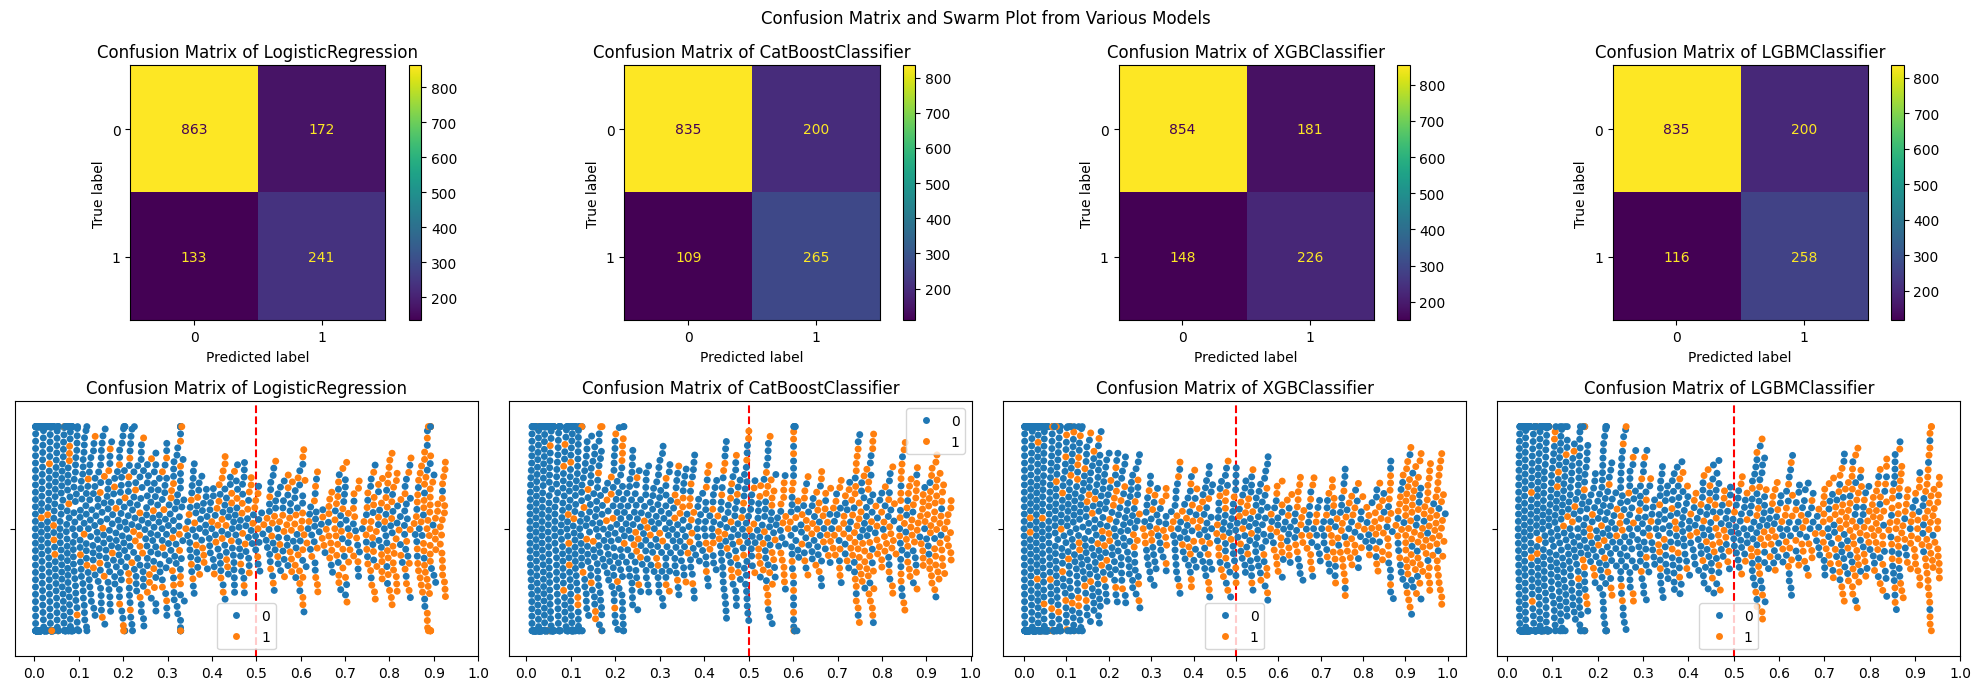

In [365]:
X_train, X_test, y_train, y_test = data_preparation(df_ori)
threshold = 0.5

recalls = []
precisions = []
f1s = []
roc_aucs = []
models = []
fig, ax = plt.subplots(ncols=len(pair_model_params), nrows=2, figsize=(20, 7))
for i, (model, params) in enumerate(pair_model_params):
    # Create Model and Predict
    # ============================================== 
    model = model(**params)
    model.fit(X_train, y_train)

    # Predict
    # ==============================================
    y_pred_proba = model.predict_proba(X_test)
    y_pred = [1 if prob > threshold else 0 for prob in y_pred_proba[:,1]]

    recalls.append(recall_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred))
    f1s.append(f1_score(y_test, y_pred))
    roc_aucs.append(roc_auc_score(y_test, y_pred))
    models.append(model.__class__.__name__)

    # confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    cmp.plot(ax=ax[0][i])
    ax[0][i].set_title(f"Confusion Matrix of {model.__class__.__name__}")

    # swarm plot
    sns.swarmplot(x=y_pred_proba[:, 1], hue=y_test.tolist(), ax=ax[1][i])
    ax[1][i].set_title(f"Confusion Matrix of {model.__class__.__name__}")
    ax[1][i].axvline(threshold, label="Threshold", color="red", linestyle="--")
    ax[1][i].set_xticks(np.arange(0, 1.001, 0.1))

fig.suptitle("Confusion Matrix and Swarm Plot from Various Models")
fig.tight_layout()

In [367]:
pd.DataFrame({
    "Model": models,
    "Recall": recalls,
    "Precision": precisions,
    "F1 Score": f1s,
    "ROC AUC": roc_aucs,
})

,Model,Recall,Precision,F1 Score,ROC AUC
0,LogisticRegression,0.644385,0.583535,0.612452,0.739101
1,CatBoostClassifier,0.708556,0.569892,0.631704,0.757660
2,XGBClassifier,0.604278,0.555283,0.578745,0.714699
3,LGBMClassifier,0.689840,0.563319,0.620192,0.748301


CatBoost is the best overall model

# Reconsideration
When it comes to presenting the results to the management, they want to be able to target actual churned customers that has high CLTV.

In [368]:
pair_model_params = [
    (LogisticRegression, {
    "C": 1.5809009892543753,
    "solver": "lbfgs",
    "max_iter": 200,
    "random_state": 42
}),
    (cb.CatBoostClassifier, {
    "objective": "Logloss",
    "colsample_bylevel": 0.055633241112555826,
    "depth": 3,
    "boosting_type": "Plain",
    "bootstrap_type": "MVS",
    "random_state": 42
}),
    (xgb.XGBClassifier, {
    "booster": "gbtree",
    "lambda": 5.075857084980238e-05,
    "alpha": 8.901719814994127e-07,
    "subsample": 0.5610237056808841,
    "colsample_bytree": 0.9182724636198594,
    "max_depth": 3,
    "min_child_weight": 2,
    "eta": 0.4453770420023173,
    "gamma": 8.588470577631825e-06,
    "grow_policy": "depthwise",
    "random_state": 42
}),
    (lgb.LGBMClassifier, {
    "lambda_l1": 9.757903390003335,
    "lambda_l2": 3.6189088264165127e-07,
    "num_leaves": 363,
    "feature_fraction": 0.5303935833932334,
    "bagging_fraction": 0.49131248078384027,
    "bagging_freq": 2,
    "min_child_samples": 200,
    "random_state": 42
})
]

In [369]:
X_train, X_test, y_train, y_test = data_preparation(df_ori)

models = []
cltvs = []
monthly_purchase = []
for (model, params) in pair_model_params:
    # Create Best Model
    # ==============================================
    model = model(**params)
    model.fit(X_train, y_train)

    # Predict using threshold 0.5
    # ==============================================
    y_pred_proba = model.predict_proba(X_test)
    y_pred = [1 if prob > 0.5 else 0 for prob in y_pred_proba[:,1]]

    # Calculate CLTV
    # ==============================================
    df = df_ori.copy()
    potentially_saved_money = df.iloc[y_test[(y_pred == y_test) & (y_test==1)].index, -1].sum()
    models.append(model.__class__.__name__)
    cltvs.append(df.loc[y_test[(y_pred == y_test) & (y_test==1)].index, "CLTV (Predicted Thou. IDR)"].sum())
    monthly_purchase.append(df.loc[y_test[(y_pred == y_test) & (y_test==1)].index, "Monthly Purchase (Thou. IDR)"].sum())

ax = pd.DataFrame({    
    "Model": models,
    "CLTV": cltvs,
    "Monthly Purchase": monthly_purchase,
    }).set_index("Model").plot.barh()

# Adding annotations to the bars
for i, v in enumerate(cltvs):
    ax.text(v + 3, i-0.1, f"Rp{v*1000:,.0f},00", va='center')

for i, v in enumerate(monthly_purchase):
    ax.text(v + 3 * 10000, i+0.1, f"Rp{v*1000:,.0f},00", color='black', va='center')

plt.xlabel("Amount in Indonesia Rupiah")
plt.title("Potential Money Saved by each Churn Model Predictions")
plt.show()

Learning rate set to 0.025403
0:	learn: 0.6931335	total: 5.32ms	remaining: 5.31s
1:	learn: 0.6902553	total: 9.06ms	remaining: 4.52s
2:	learn: 0.6860054	total: 11.9ms	remaining: 3.96s
3:	learn: 0.6860127	total: 14.1ms	remaining: 3.5s
4:	learn: 0.6821621	total: 16.7ms	remaining: 3.31s
5:	learn: 0.6795888	total: 19.5ms	remaining: 3.23s
6:	learn: 0.6712381	total: 22.2ms	remaining: 3.15s
7:	learn: 0.6641744	total: 24.5ms	remaining: 3.03s
8:	learn: 0.6611009	total: 26.3ms	remaining: 2.89s
9:	learn: 0.6572663	total: 28ms	remaining: 2.77s
10:	learn: 0.6535570	total: 30.2ms	remaining: 2.72s
11:	learn: 0.6509310	total: 31.7ms	remaining: 2.61s
12:	learn: 0.6492019	total: 33.3ms	remaining: 2.52s
13:	learn: 0.6442704	total: 35.8ms	remaining: 2.52s
14:	learn: 0.6414692	total: 37.4ms	remaining: 2.46s
15:	learn: 0.6363182	total: 39ms	remaining: 2.4s
16:	learn: 0.6343071	total: 40.4ms	remaining: 2.34s
17:	learn: 0.6289043	total: 42ms	remaining: 2.29s
18:	learn: 0.6275908	total: 43.6ms	remaining: 2.25s
